# Project 1: がんのトランスクリプトーム解析 (10:00-10:50)

**この時間の目的**

バルクの遺伝子発現量データを公共データベースからダウンロードし、正常とがんを正しく分類する問題を通して、AIの基礎事項やバイオインフォマティクスとの接続を学びます。

ご質問はzoomではなく、**Slackの** **(#質問箱)** にお願いします。
Slackであればzoom終了後にも残りますので、時間内で回答できなかった質問に対しても回答させていただきます。

In [ ]:
# 使用するライブラリのインストールとインポートを行う (1分程度かかる場合があります)
!pip install GEOparse -q
!pip install optuna -q
%matplotlib inline
import GEOparse
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import sklearn
import torch

In [ ]:
# バージョンの確認
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('sklearn: ', sklearn.__version__)
print('seaborn: ', sns.__version__)
print('optuna: ', optuna.__version__)
print('torch: ', torch.__version__)

# 1. 教師あり学習のためのデータ前処理

**目的**

機械学習分類器を構築するための前処理を学ぶことを目標とする。その際、解析における様々な注意点や分類器の特徴などを解説する。

**題材**

GSE36376: 肝細胞がんの公共マイクロアレイデータセット ([Lim HY et al., *Ann. Surg. Oncol*. 2013](https://link.springer.com/article/10.1245/s10434-013-3070-y))

**方法**
まずは`GEOparse`ライブラリを用いてこのデータにアクセスし、前処理を行う。

このデータを用いて、肝細胞がんと隣接正常肝臓の分類を行う機械学習モデルを構築する。次のセクションでは古典的な機械学習モデルであるサポートベクトルマシン、そしてその次のセクションでは深層学習モデルであるニューラルネットワークを用いて構築を行う。

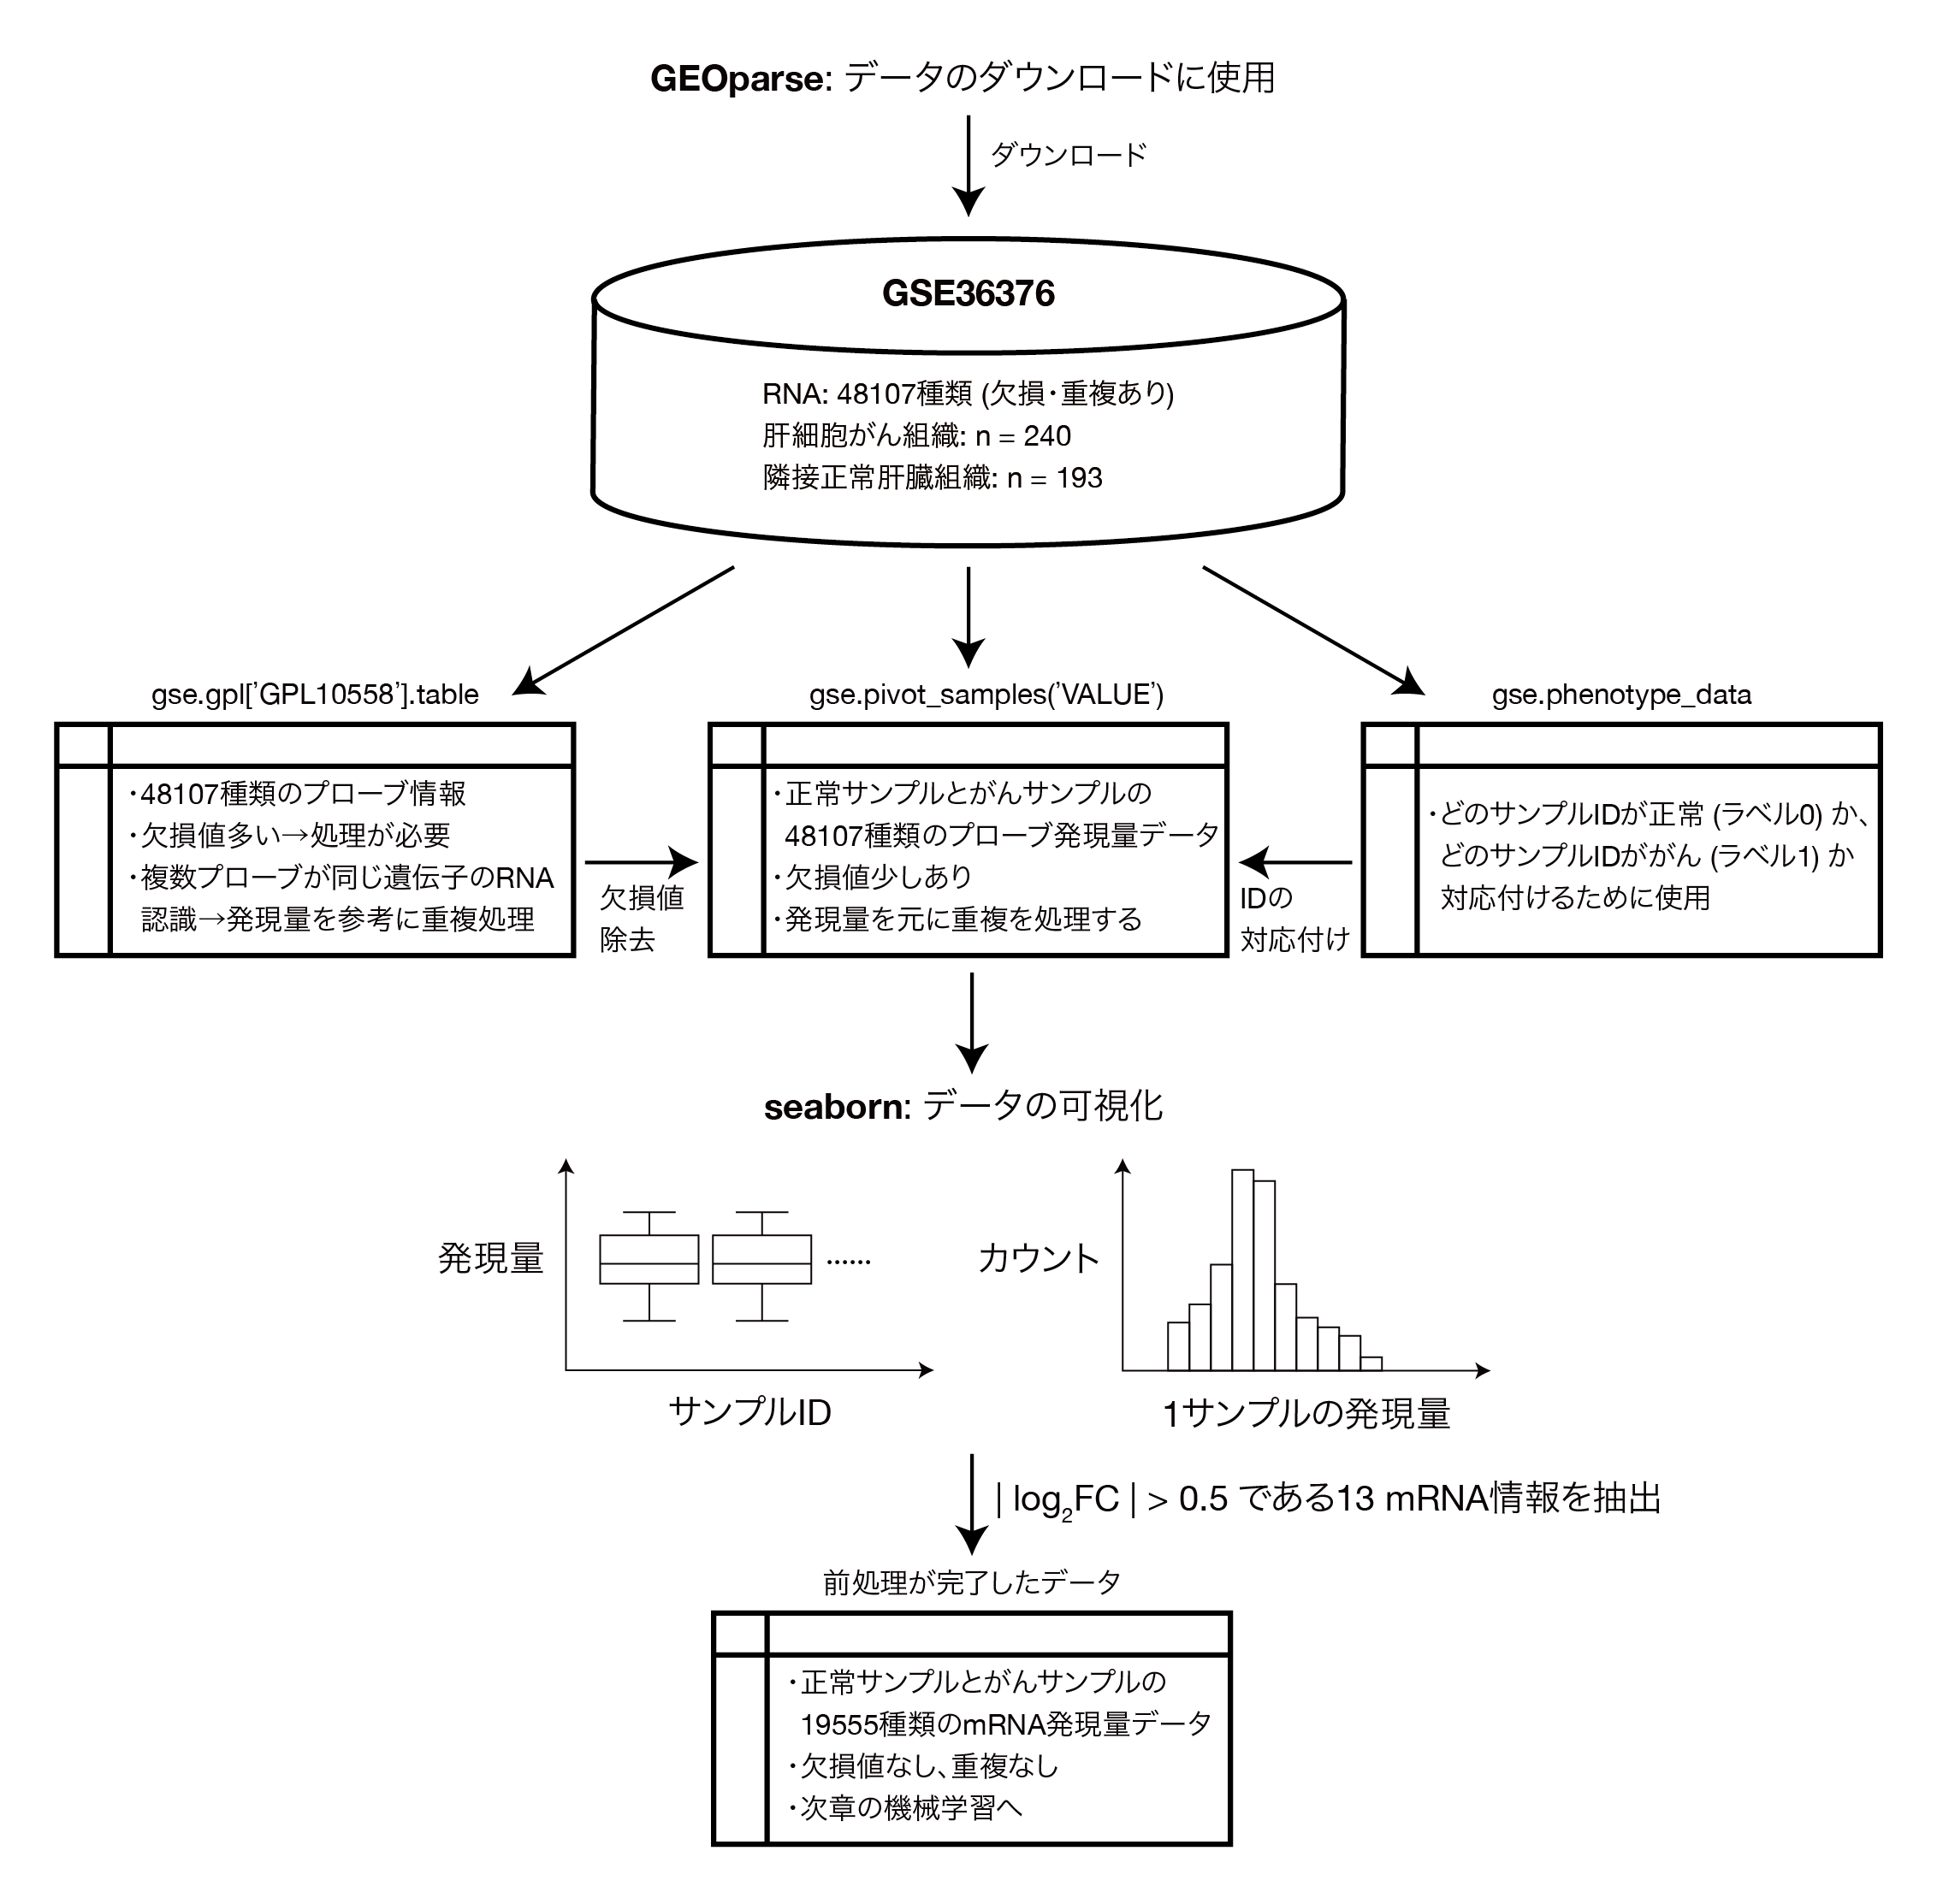

## 1-1. データのダウンロード

まずは、`GEOparse`ライブラリを用いて肝細胞がんと隣接正常肝臓のデータの読み込みを行う。

In [ ]:
# 1-1-1 GSE36376の読み込み (2分程度かかる場合があります)
gse = GEOparse.get_GEO(geo = "GSE36376")
gse_table = gse.gpls['GPL10558'].table

こうして読み込んだ`gse`の中には様々なデータが含まれている。気になる方は[公式ドキュメント](https://geoparse.readthedocs.io/en/latest/introduction.html)を読んでみてほしい。

ここで扱う中で重要なデータは以下の3つである。

*   `gse.gpls['GPL10558'].table`: 各遺伝子に対応するマイクロアレイプラットフォームについての基本情報
*   `gse.phenotype_data`: 各肝臓サンプルの基本情報
*   `gse.pivot_samples('VALUE')`: 遺伝子発現量データ

In [ ]:
# 1-1-2 各遺伝子についての基本情報 (gse.gpls['GPL10558'].table) を見てみる
pd.set_option('display.max_columns', 30) # 30列全てを見えるようにする
gse_table = gse.gpls['GPL10558'].table
gse_table

このデータで重要となってくる列について見ておこう。

*   `ID`: マイクロアレイを行う際のプローブのID
*   `Species`: サンプルの種 (`'Homo sapiens'`ならヒト由来)
*   `Source`: サンプルの参照配列 (`'RefSeq'`なら核酸データベース: [NCBI Reference Sequence Database](https://www.ncbi.nlm.nih.gov/refseq/) を指す)
*   `RefSeq ID`: NCBI Reference Sequence Database に登録されている参照配列ID
*   `Symbol`: 遺伝子名
*   `SEQUENCE`: 遺伝子配列


さて、このデータでまず目に入るのは、1番上の行、NaNばかりの部分だろう。`Species`すらNaNであり、明らかに除外すべきデータであると考えられる。

そして、下の方の行を見ると同じ遺伝子シンボルが複数 (`'SKCG-1'`が2つと`'ESP33'`が2つ) あるのが見て取れる。`ID`や`SEQUENCE`を確認すると、異なるプローブが同じ遺伝子の異なる部位を認識しているとわかる。複数の異なるプローブが1つの遺伝子の異なる部位に結合するということで、多プローブと1遺伝子が対応している状態である。これについては後で1つの代表的なプローブ以外のデータを捨てることで重複を除外し、1プローブ1遺伝子にすることに留意しておこう。

このデータフレームには48107行含まれているが、明らかにタンパクをコードする遺伝子数20000より多いと考えられる。重複が想像より多いかもしれないし、あるいはmRNAだけでなくnon-coding RNAやその他核酸を多く含んでいるかもしれない。また、欠損値が多すぎるのかもしれないので、48107行のうち一体どれほどがNaNばかりの行なのかも気になるところだろう。


---
**補足**


プローブとはマイクロアレイ用のチップ上に固定してあるDNA配列であり、これと相補的なRNA配列が結合するようになっている。基本的には1つのプローブは1つの遺伝子のRNAのみと結合するように設計されている ([Wang et al., *Nat. Biotechnol.*, 2014](https://www.ebi.ac.uk/biostudies/arrayexpress))。

NCBI Reference Sequence Databaseからはゲノムや転写産物、タンパク質の塩基配列やアミノ酸配列の情報が得られる。`RefSeq_ID`にはAccession番号というIDが割り振られており、接頭語3文字でその配列の種類を示している。最初の三文字が`'NM_'`なら**mRNA配列**、`'XM_'`なら**予測されたmRNA配列**、`'NR_'`なら**non-coding RNA配列**、`'XR_'`なら**予測されたnon-coding RNA配列**である。

---


## 1-2. データの前処理

続いて、読み込んだデータの前処理を行い、肝細胞がんと隣接正常肝臓の19555種類のmRNA発現量データを抽出する。

まずは、これらのデータにどれほど欠損値があるかを考えよう。`pandas`ライブラリの`info()`メソッドを使えば、非欠損値がわかる。

In [ ]:
# 1-2-1 欠損値ではないデータ数を調べる
gse_table = gse.gpls['GPL10558'].table
gse_table.info()

ヒトの肝細胞がんと隣接正常肝臓のデータを考える上で、例えば`Species`が欠損しているデータに価値があるとは思えない。ここでは`Species`が`'Homo sapiens'`に一致するものを抽出することで、欠損値を除去してみよう。

また、`Symbol`の欠損値も除去しよう。遺伝子名が存在しない配列の中にも重要なものがある可能性は否定できないが、一般的には除去することが多い。

さらに、今回はmRNAのみを考えることにする。

In [ ]:
# 1-2-2 ヒトのmRNAで遺伝子名が存在するもののみを抽出
# 'Species'列が'Homo sapiens'に一致するもののみを抽出 ('Homo sapiens'ということで'_hs'を末尾につける)
gse_table_hs = gse_table[gse_table['Species'] == 'Homo sapiens']

# 'Symbol'列の欠損値をdropnaで除去 ('Symbol'ということで'_sym'を末尾につける)
gse_table_hs_sym = gse_table_hs.dropna(subset = ['Symbol'])

# mRNAのみということで'_NM'を末尾につける
gse_table_hs_sym_NM = gse_table_hs_sym[gse_table_hs_sym['RefSeq_ID'].str[:3] == 'NM_']

In [ ]:
# 1-2-3 抽出してきたデータの前処理 (30秒くらいかかる場合があります)
# 'ID'列と'Symbol'列が存在するヒトのmRNAデータフレームを作成
col = ['ID', 'Symbol']
gse_selected = gse_table_hs_sym_NM[col]

# 'ID'列をヒトのmRNAデータフレームのインデックスに指定
gse_selected.index = gse_selected['ID']

# 'Symbol'列のみを含むデータフレームを作成
gse_selected = pd.DataFrame(gse_selected['Symbol'])

# サンプルの行と列を入れ替える
pivoted_samples = gse.pivot_samples('VALUE')

# ヒトのmRNAデータフレームのIDに一致するデータのみを抽出
pivoted_samples_mRNA = pivoted_samples.loc[gse_selected.index,]

# 平均発現量を計算して新しい列として追加
pivoted_samples_mRNA['Amean'] = pivoted_samples_mRNA.mean(axis = 1)

# 'Symbol'列を含むデータフレームとヒトのmRNAデータフレームを結合
gse_pivoted_merge = pd.merge(gse_selected, pivoted_samples_mRNA, left_index = True, right_index = True)

# 平均発現量で並び替え
gse_pivoted_merge_sorted = gse_pivoted_merge.sort_values(['Amean'], ascending = False)

# 'Symbol'列に基づいて重複を取り除く
gse_pivoted_merge_sorted_unique = gse_pivoted_merge_sorted.drop_duplicates(['Symbol'], keep = 'first')

# インデックスを'Symbol'列に指定
gse_pivoted_merge_sorted_unique.index = gse_pivoted_merge_sorted_unique['Symbol']

# 'Symbol'列と'Amean'列を削除
gse_mRNA_exprs = gse_pivoted_merge_sorted_unique.drop(['Symbol', 'Amean'], axis = 1)

In [ ]:
# 1-2-4 前処理が完了したデータフレームの確認
gse_mRNA_exprs

## 1-3. 特徴量の選択

ここでは、肝細胞がんか正常肝臓かを判断できそうなmRNAの候補を選択する。

現在、19555種類のmRNA情報が得られているが、この19555種類のmRNAを全て使った機械学習のモデルを構築することは (可能ではあるだろうが) 不適切だろう。そのような分類器では、もし新しいデータが得られて、それが肝細胞がんか正常肝臓かを判断したいと考えたとき、19555種類のうち1種類でもデータが欠失してしまえば分類不可能になってしまう (そもそも19555種類ものmRNA情報を調べ上げるのは面倒かつ金銭的にも望ましくない) 。

そのためここでは、肝細胞がんか正常肝臓かを判断できそうな候補を予め19555種類からある程度選択しておくことにする。その候補を、**fold change** (**FC**) が大きいものという形で選ぶことにしよう。

Fold changeはこの手のデータを扱うときによく使う単純な統計量で、日本語にすると「倍率変化」である。例えば遺伝子Aが、がんサンプルで平均発現量10、正常サンプルで平均発現量5だったとき、平均発現量のFCは10/5 = 2、つまり2倍である。実際にはFC自体よりも、2を底とする対数をとった**log2FC**が使われることが多い。この場合、先の例のFC = 2は、log2FC = 1となる。例えば、2倍と1/2倍という値があったとき、log2FCだとそれぞれ1と−1になる。

では実際に、gse_mRNA_exprsで定義された発現量データについて、fold changeを基準とした上で、肝細胞がんと正常肝臓に分けることにしよう。



In [ ]:
# 1-3-1 phenotype_dataから正常サンプルと腫瘍サンプルのIDのみを抜き出す
gse_phenotype = gse.phenotype_data
normal_ID = gse_phenotype[gse_phenotype['characteristics_ch1.0.tissue'] == 'adjacent non-tumor liver'].index
tumor_ID = gse_phenotype[gse_phenotype['characteristics_ch1.0.tissue'] == 'liver tumor'].index
gse_mRNA_exprs_normal = gse_mRNA_exprs[normal_ID]
gse_mRNA_exprs_tumor = gse_mRNA_exprs[tumor_ID]
FC = gse_mRNA_exprs_tumor.mean(axis = 1) / gse_mRNA_exprs_normal.mean(axis = 1)

In [ ]:
# 1-3-2 各遺伝子について、正常サンプル(の平均)に対するがんサンプル(の平均)のlog2FCを計算
threshold = 0.5
log2FC = np.log2(FC)
FC_selected_mRNA = list(log2FC[log2FC.abs() > threshold].index)
gse_mRNA_exprs_normal_selected = gse_mRNA_exprs_normal.loc[FC_selected_mRNA, :]
gse_mRNA_exprs_tumor_selected = gse_mRNA_exprs_tumor.loc[FC_selected_mRNA, :]

In [ ]:
# 1-3-3 log2FCの絶対値が0.5以上のmRNAの行を抽出 (正常サンプルと腫瘍サンプルのIDのみを抜き出す)
normal_ID = gse_phenotype[gse_phenotype['characteristics_ch1.0.tissue'] == 'adjacent non-tumor liver'].index
tumor_ID = gse_phenotype[gse_phenotype['characteristics_ch1.0.tissue'] == 'liver tumor'].index

## 1-4. データの可視化と保存
最後に、前処理によって得られたmRNAの発現量データを確認する。

数値がたくさん集まったデータは人間が解釈するにはあまりにも複雑すぎる。こういったデータを扱う前には、グラフなどで**可視化**することでデータの概形を掴むのがセオリーである。データの特徴をわかっていればより良い学習ができることも多い。また、グラフ化してデータの問題点などに気がついたら、計算ミスやコードの記述ミスに気づけたり、除外すべき変数を見つけ出したり、他の前処理法を試したりできるかもしれない。

In [ ]:
# 1-4-1 IDごとのデータの可視化
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# 箱ひげ図を左側のAxesに描画
sns.boxplot(data = pivoted_samples.iloc[:, 0:5], ax = axes[0])
axes[0].set_title('Boxplot')
axes[0].set_xlabel('ID')
axes[0].set_ylabel('Value')

# ヴァイオリンプロットを右側のAxesに描画
sns.violinplot(data = pivoted_samples.iloc[:, 0:5], ax = axes[1])
axes[1].set_title('Violin Plot')
axes[1].set_xlabel('ID')
axes[1].set_ylabel('Value')

# グラフの表示
plt.tight_layout()
plt.show()

データ全体を整然データに変換したところで、以下の図で、左にNormal sampleの violin plot、右にTumor sampleのviolin plotをおいている。log2FCの絶対値が0.5より大きいという条件で選んできているだけあって、左右で分布が異なることがわかるだろう。

In [ ]:
# 1-4-2 Symbolごとのデータの可視化
gse_mRNA_exprs_normal_selected_tidy = pd.melt(gse_mRNA_exprs_normal_selected.T)
gse_mRNA_exprs_normal_selected_tidy['class'] = 'Normal sample'
gse_mRNA_exprs_tumor_selected_tidy = pd.melt(gse_mRNA_exprs_tumor_selected.T)
gse_mRNA_exprs_tumor_selected_tidy['class'] = 'Tumor sample'
gse_mRNA_exprs_selected_tidy = pd.concat([gse_mRNA_exprs_normal_selected_tidy, gse_mRNA_exprs_tumor_selected_tidy], axis = 0)
plt.figure(figsize = (15, 8))

# quartileで中央値と四分位数のところに線を引いている
sns.violinplot(
    data = gse_mRNA_exprs_selected_tidy,
    x = 'Symbol',
    y = 'value',
    hue = 'class',
    split = True,
    inner = 'quartile')

In [ ]:
# 1-4-3 正常とがんのデータをcsvファイルで保存
gse_mRNA_exprs_normal_selected.to_csv('GSE36376_normal.csv')
gse_mRNA_exprs_tumor_selected.to_csv('GSE36376_tumor.csv')

# 2. scikit-learnを用いたトランスクリプトームデータの分類

**目的**

ここでは有用な機械学習ライブラリである`scikit-learn`を利用して、サポートベクトルマシン (SVM) による簡単な機械学習分類器を構築することを目標とする。その際、解析における様々な注意点や分類器の特徴などを解説する。

**題材**

肝細胞がんの公共マイクロアレイデータセット (GSE36376) から抽出した、正常サンプルとがんサンプルで発現変動量が大きかった19555種類のヒトのmRNA発現量データ

**方法**

ここでは、まずサポートベクトルマシンによる肝細胞がんと隣接正常肝臓の分類を行う機械学習モデルを構築する。また、より良いモデルを目指して検証データセットの導入と交差検証法による評価、およびハイパーパラメータの調整を行う。

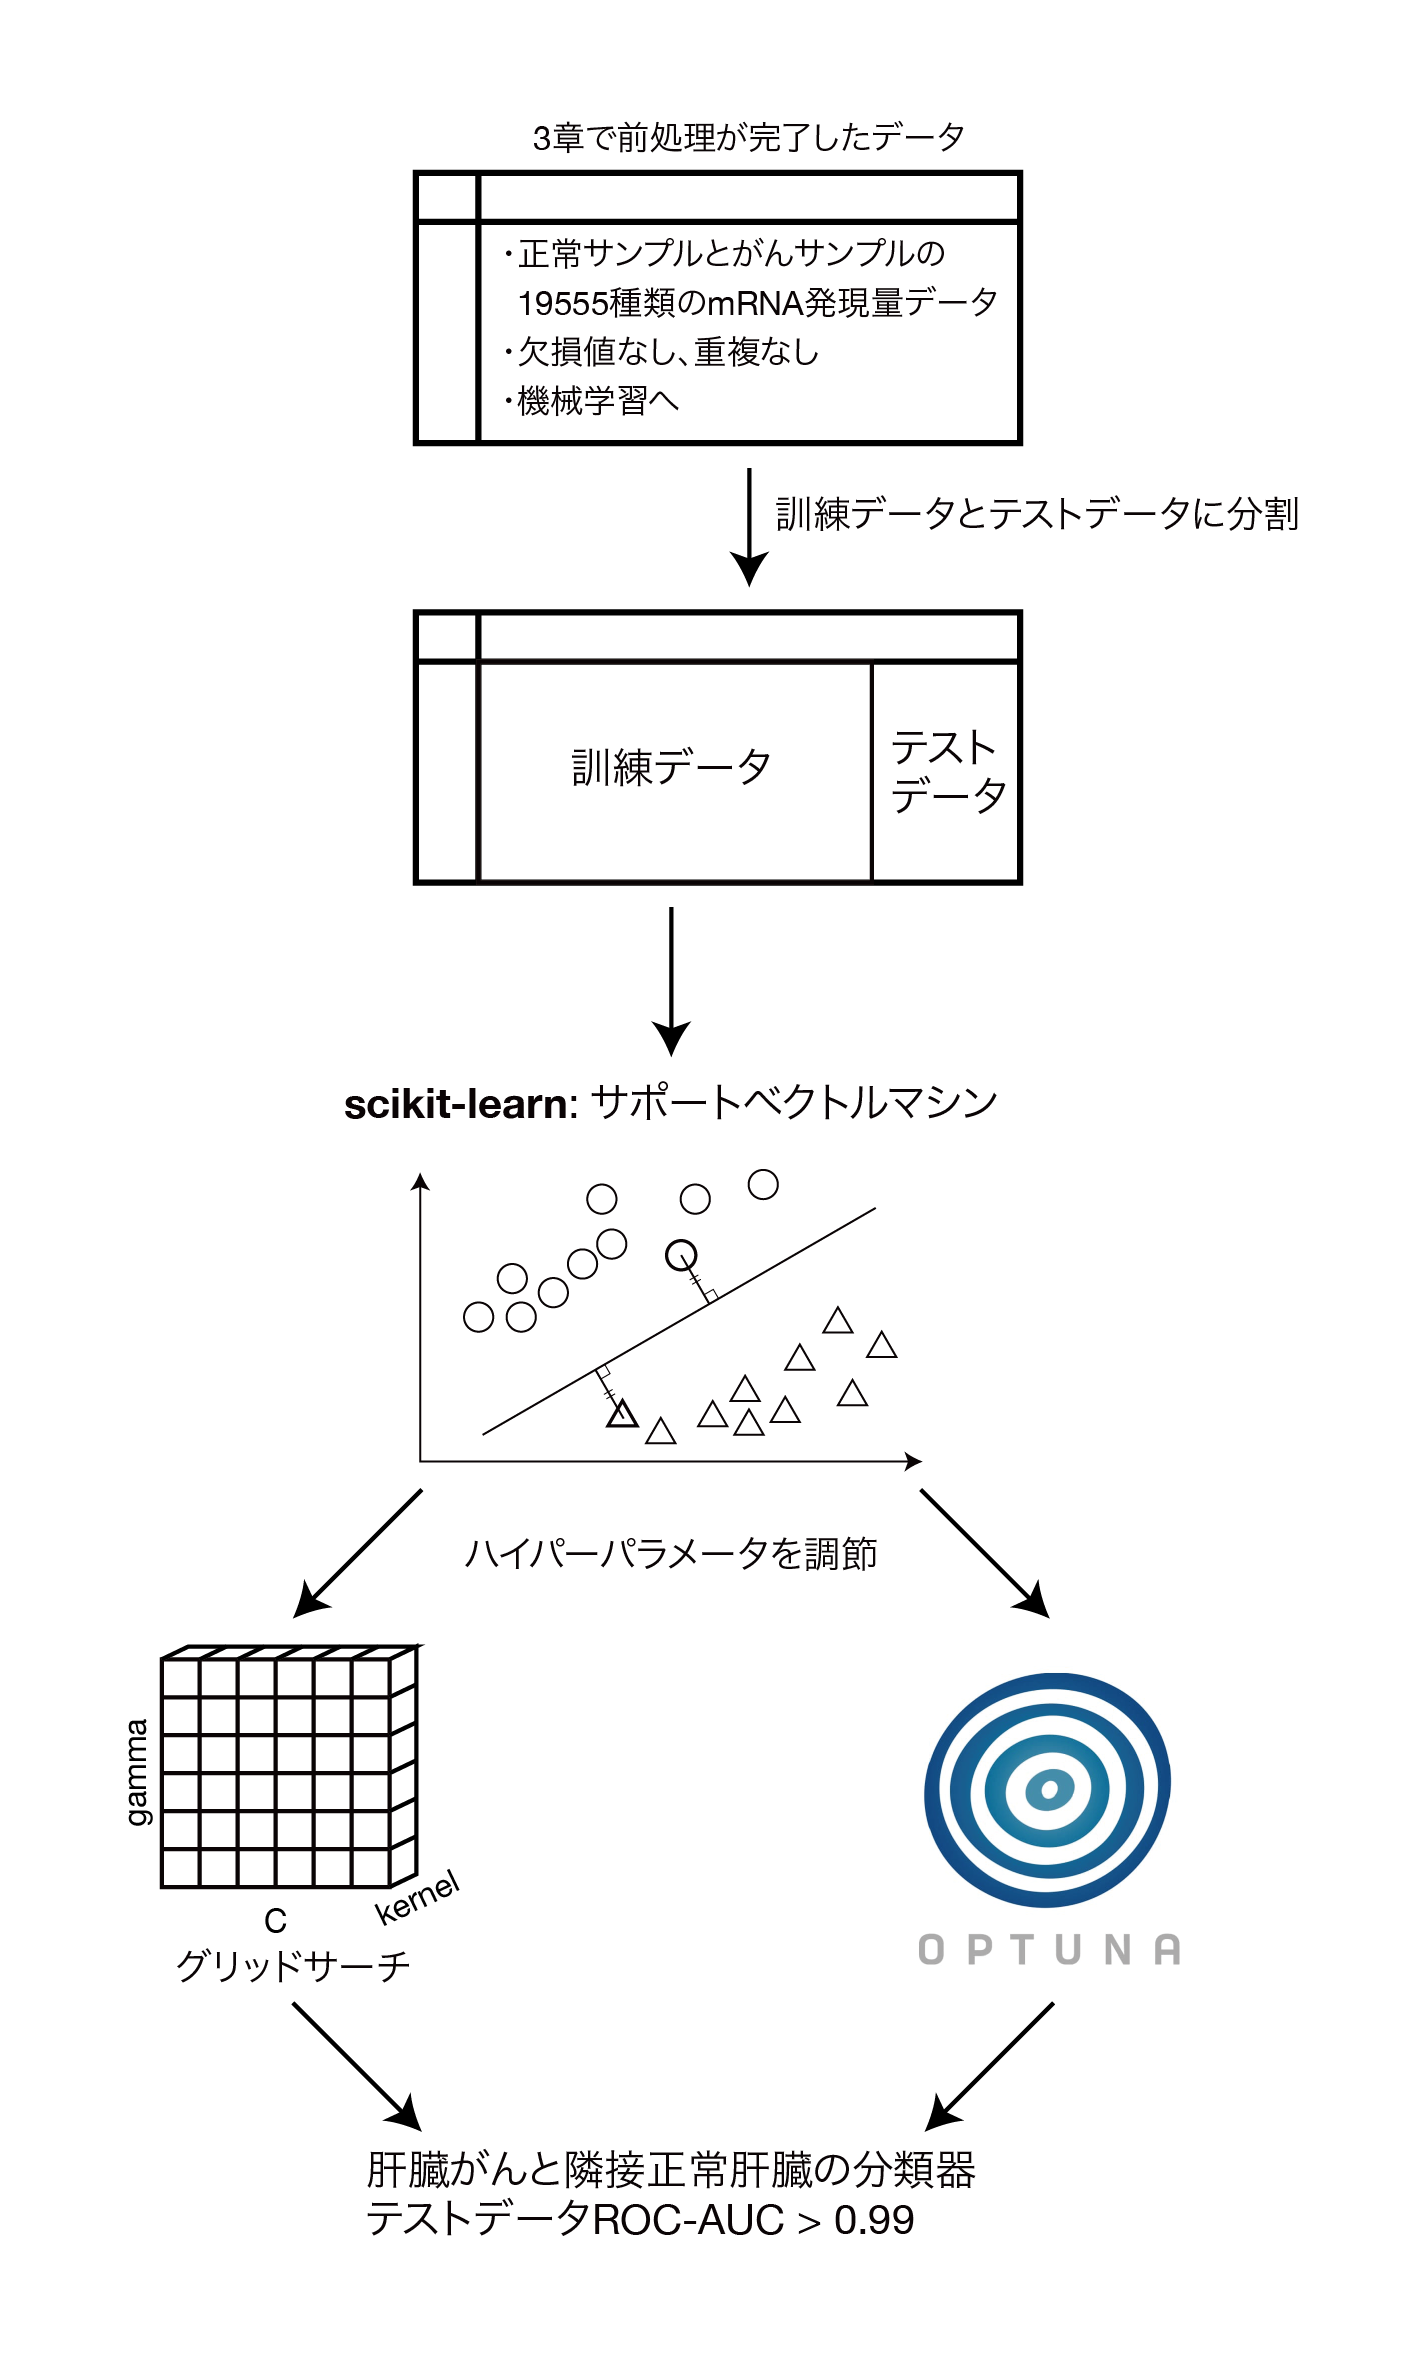

なお、Optuna™のロゴマークは[PFN社のホームページ](https://www.preferred.jp/ja/projects/optuna/)
から引用した。


## 2-1. サポートベクトルマシンの実装

先ほど作成したデータを使用して、サポートベクトルマシンを実装する。具体的には、元のデータを訓練データとテストデータに分割して標準化を行ったのち、学習を行う。評価はROC曲線のAUCや混合行列によって行う。

**データの分割と前処理**

まずは学習の際に用いる訓練データと性能評価に用いるテストデータを作成する。

正常サンプルなら0、がんサンプルなら1となるような`class`ラベルを作成し、学習における正解データ (`y`) とする。次に、`sklearn.model_selection`モジュールの`train_test_split`関数を用いて、ランダムに訓練データ (75%) とテストデータ (25%) に分割する。これらのデータを`X_train`, `y_train`, `X_test`, `y_test`とする。

In [ ]:
# 2-1-1 先ほど作成したデータを分割する
# 正常サンプルなら0、がんサンプルなら1となるようなclassラベルを作成する
gse_mRNA_exprs_normal_selected.loc['class'] = 0
gse_mRNA_exprs_tumor_selected.loc['class'] = 1

# 簡単な分類器を作るために、train_test_split関数でデータをランダムに分割する
from sklearn.model_selection import train_test_split

# 転置したデータを訓練データ (75%) とテストデータ (25%) に分ける
gse_mRNA_exprs_normal_selected_train, gse_mRNA_exprs_normal_selected_test = train_test_split(gse_mRNA_exprs_normal_selected.T, train_size = 0.75, random_state = 0)
gse_mRNA_exprs_tumor_selected_train, gse_mRNA_exprs_tumor_selected_test = train_test_split(gse_mRNA_exprs_tumor_selected.T, train_size = 0.75, random_state = 0)

# 訓練データを作り出す
gse_mRNA_exprs_train = pd.concat([gse_mRNA_exprs_normal_selected_train, gse_mRNA_exprs_tumor_selected_train])

# 各mRNAの発現量を特徴量として、X_trainを作成
X_train = gse_mRNA_exprs_train.iloc[:, 0:-1]

# classラベルを目的変数として、y_trainを作成
y_train = gse_mRNA_exprs_train.iloc[:, -1]

# テストデータを作り出す
gse_mRNA_exprs_test = pd.concat([gse_mRNA_exprs_normal_selected_test, gse_mRNA_exprs_tumor_selected_test])

# 各mRNAの発現量を特徴量として、X_testを作成
X_test = gse_mRNA_exprs_test.iloc[:, 0:-1]

# classラベルを目的変数として、y_testを作成
y_test = gse_mRNA_exprs_test.iloc[:, -1]

In [ ]:
# 2-1-2 データの確認
X_train.describe()

さて、ここで一般的には各列の平均を0、分散を1にする、**標準化** (standardization) という前処理法を使う。これは元々のデータの特徴量ベクトル$ \mathbf{x}_{\normalsize train}$から、その特徴量の平均値$ \mu_{\normalsize train}$を差し引いて、標準偏差$ \sigma_{\normalsize train}$で割れば実現される。例えば、13種の遺伝子の一つ、`MT1G`列の訓練データセットとテストデータセットを標準化する場合、式は以下のようになる。

$$
\LARGE \mathbf{x}_{\normalsize train\_std\_MT1G} = \frac{\LARGE \mathbf{x}_{\normalsize train\_MT1G} - \LARGE \mu_{\normalsize train\_MT1G}}{\LARGE \sigma_{\normalsize train\_MT1G}} \\
\quad \\
\quad \\
\LARGE \mathbf{x}_{\normalsize test\_std\_MT1G} = \frac{\LARGE \mathbf{x}_{\normalsize test\_MT1G} - \LARGE \mu_{\normalsize train\_MT1G}}{\LARGE \sigma_{\normalsize train\_MT1G}}
$$

これは`sklearn.preprocessing`モジュールの`StandardScaler`クラスで簡単に実行できる。基本的には訓練データセットで`fit`メソッドを行うことにより、平均0、分散1となるような計算を学習させた後に訓練データセットとテストデータセットに対して`transform`メソッドを行う。これにより訓練データセットから、訓練データセットの平均値が差し引かれ、訓練データセットの標準偏差で割ることで平均0、分散1に変換される。一方で、テストデータセットからは、訓練データセットの平均値が差し引かれ、訓練データセットの標準偏差で割ることになるため、厳密な意味で平均0、分散1にはならない。


---
**補足**

今回は学習に使う特徴量が全て遺伝子であり、元々quantile正規化を行っていたデータであるため、標準化の恩恵はそこまで大きいわけではない。

ただ、単位が異なるものを標準化で揃えることは学習に役立つ。例えば物件の家賃を予測する回帰タスクを機械学習に任せたいとき、特徴量に「築年数 (築1年、築10年など)」と「最寄り駅の距離 (100メートル、3000メートル)」があった場合、標準化で築年数は築年数のデータのみを用いて平均0、分散1に、最寄り駅の距離は最寄り駅の距離のデータのみを用いて平均0、分散1にすることができる。

---


In [ ]:
# 2-1-3 データの標準化
from sklearn.preprocessing import StandardScaler

# StandardScalerのfitメソッドでトレーニングデータの平均値と標準偏差の情報をscに与える
sc = StandardScaler()
sc.fit(X_train)

# トレーニングデータの平均と標準偏差を元に標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# データフレーム型にして確認
X_train_std_df = pd.DataFrame(X_train_std)
X_test_std_df = pd.DataFrame(X_test_std)

# 浮動小数点数の関係で平均は完全に0になるわけではなく、標準偏差も完全に1ではない
X_train_std_df.columns = X_train.columns
X_test_std_df.columns = X_test.columns

In [ ]:
# 2-1-4 標準化されたデータの確認
X_test_std_df.describe()

**サポートベクトルマシンの導入**

さて、ここで最初に導入する機械学習アルゴリズムは**サポートベクトルマシン** (SVM: support vector machine) である。この手法は古典的ということで、新進気鋭のニューラルネットワークなどと比べ軽視されがちであるが、サンプルサイズが小さい場合には、ニューラルネットワークと比較してサポートベクトルマシンの方が有利である。サンプル数の稼げないことの多い生物医学分野では無視できないアルゴリズムである。

以下の図は、二次元平面の例でデータを訓練データとテストデータに分割し、訓練データでサポートベクトルマシンを学習し、テストデータに適用したものになっている。

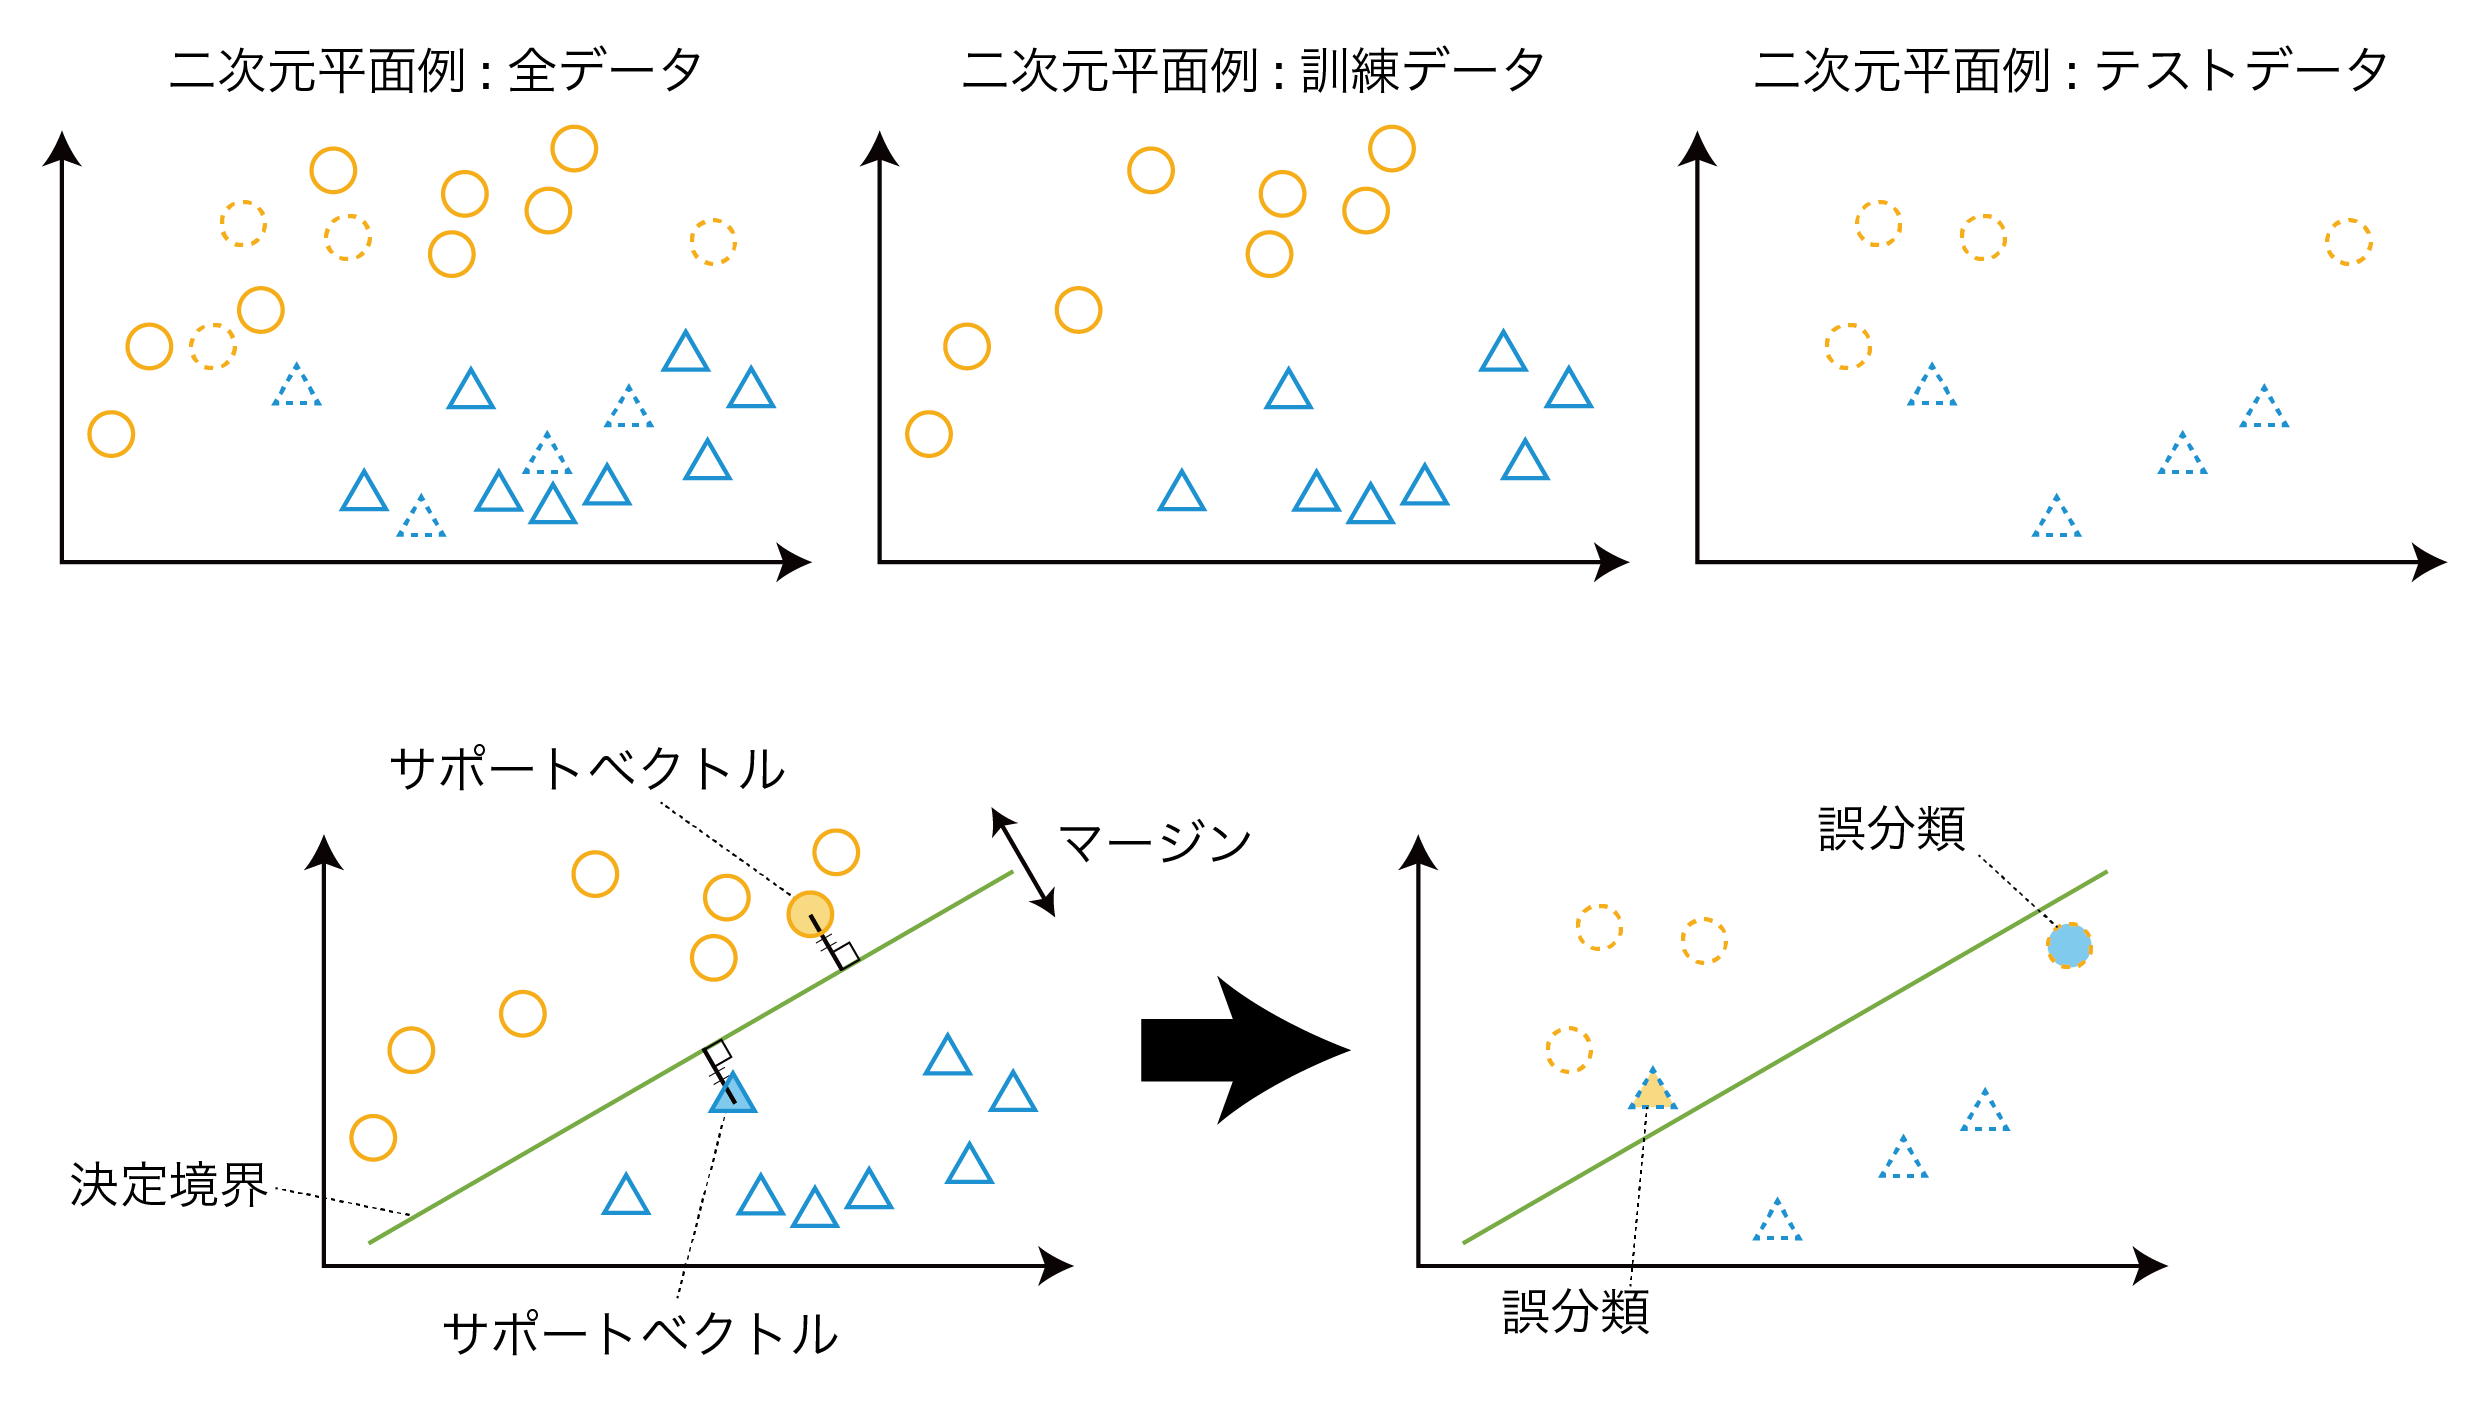

図の左下には、○と△の点、そしてそれらを分断する境界がある。この境界は、最も近い○の点と、最も近い△の点から等しい距離にある。この、最も近い点を**サポートベクトル**と言う。また、境界線を**決定境界**と言い、サポートベクトルと決定境界の距離を**マージン**と言う。サポートベクトルマシンとは、マージンを最大化するような決定境界を作ることで二つのラベルを分別するアルゴリズムである。現在、決定境界は二次元平面上にあるので線になっているが、3次元以上のデータを扱う場合は超平面となる。

サポートベクトルマシンの利点として、調整すべき**ハイパーパラメータ**が少ないという点が挙げられる。ハイパーパラメータとは、機械学習をする際に人間が決めなければならない、アルゴリズムの挙動に影響するパラメータのことを言う。より良いスコアを得るためにはハイパーパラメータを微調整しなければならないが、ハイパーパラメータの微調整はあまり簡単ではないため、ハイパーパラメータの少ないアルゴリズムは扱いやすいのである。

ここでは、サポートベクトルマシンのハイパーパラメータとして`kernel`, `C`, `gamma`の三種類を扱う。`kernel`は「決定境界をどのように決定するか」というパラメータであり、ここでは`'linear'`、つまり直線で決定境界を作るという設定である。`C`は「学習過程でどれくらい誤分類を認めるか」、`gamma`は「一つのサンプルがどれくらい影響を与えるか」のパラメータである。

In [ ]:
# 2-1-5 ようやく分類器を扱ってみる
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

# 線形SVMのインスタンスを生成する (ハイパーパラメータはとりあえずC = 1, gamma = 1)
clf = SVC(kernel = 'linear', C = 1, gamma = 1, random_state = 0, probability = True)

# 線形SVMのモデルにトレーニングデータを適合させる
clf.fit(X_train_std, y_train)

# 標準化された訓練データ (X_train_std) がラベル1である確率を算出 (y_train_pred)
y_train_pred = clf.predict_proba(X_train_std)[:, 1]
roc_auc_score(y_train, y_train_pred)

# predictメソッドではラベルを返すが、predict_probaメソッドでは確率を返す
# 例えば、clf.predict_proba(X_train_std)[:, 1]の結果、ラベル1である確率が0.05だったサンプルについてclf.predict(X_train_std)の値は0になる

In [ ]:
# 2-1-6 test scoreは？
y_pred = clf.predict_proba(X_test_std)[:, 1]
test_score = roc_auc_score(y_test, y_pred)
print(test_score)

In [ ]:
# 2-1-7 ROC曲線
from sklearn.metrics import auc, roc_curve

# ROC-AUCの計算
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)

# plotを作成
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr_test, tpr_test, label = 'SVM (AUC = %.3f)' % auc_test)
plt.fill_between(fpr_test, tpr_test, 0, alpha = 0.1)
plt.legend()
plt.title('SVM')
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.grid(True)
plt.show()

ROC曲線を見てもわかるように、非常に良い分類器だと言えそうである。他の分類指標も確認してみよう。`sklearn.metrics`モジュールの`confusion_matrix`関数は混同行列を作る関数である。

In [ ]:
# 2-1-8 混同行列 (i番目のy_predが0.5より大きい場合1に、そうでない場合0に変換する)
from sklearn.metrics import classification_report, confusion_matrix
y_pred_label = [1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))]
confusion_matrix(y_test, y_pred_label)

上の混同行列$\begin{bmatrix}
49 & 0 \\
5 & 55 \\
\end{bmatrix}
$について、左上の49という値が「ラベル0だと予測して実際に0だったサンプル数 (true negative)」、右上の0が「ラベル1だと予測したが実際には0だったサンプル数 (false positive)」、左下の5という値が「ラベル0だと予測したが実際は1だったサンプル数 (false negative)」、右下の55が「ラベル1だと予測して実際に1だったサンプル数 (true positive)」である。混同行列では対角成分の値が大きいほうが望ましい結果と言える。この結果では誤分類は5つのみであることがわかる。

次に示すのが`classification_report`関数である。これは`precision`, `recall`, `f1-score`, `accuracy`などの基本的な分類指標を幅広くカバーしており非常に役立つ。

In [ ]:
# 2-1-9 classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_label))

結果を見ると、`precision`, `recall`, `f1-score`, `accuracy`いずれも0.9を超えていることがわかる。ハイパーパラメータ、`kernel = 'linear'`, `C = 1`, `gamma = 1`という条件のサポートベクトルマシンは良い分類器だと考えられる。

下の`macro avg`や`weighted avg`は、マクロ平均、重み付き平均のことである。ラベル数が3つ以上の際に用いる分類指標で、二値分類をしている現在あまり重要ではない。多クラス分類を行う際に是非勉強してほしい。

ここまでのワークフローを簡単にまとめた図が下である。

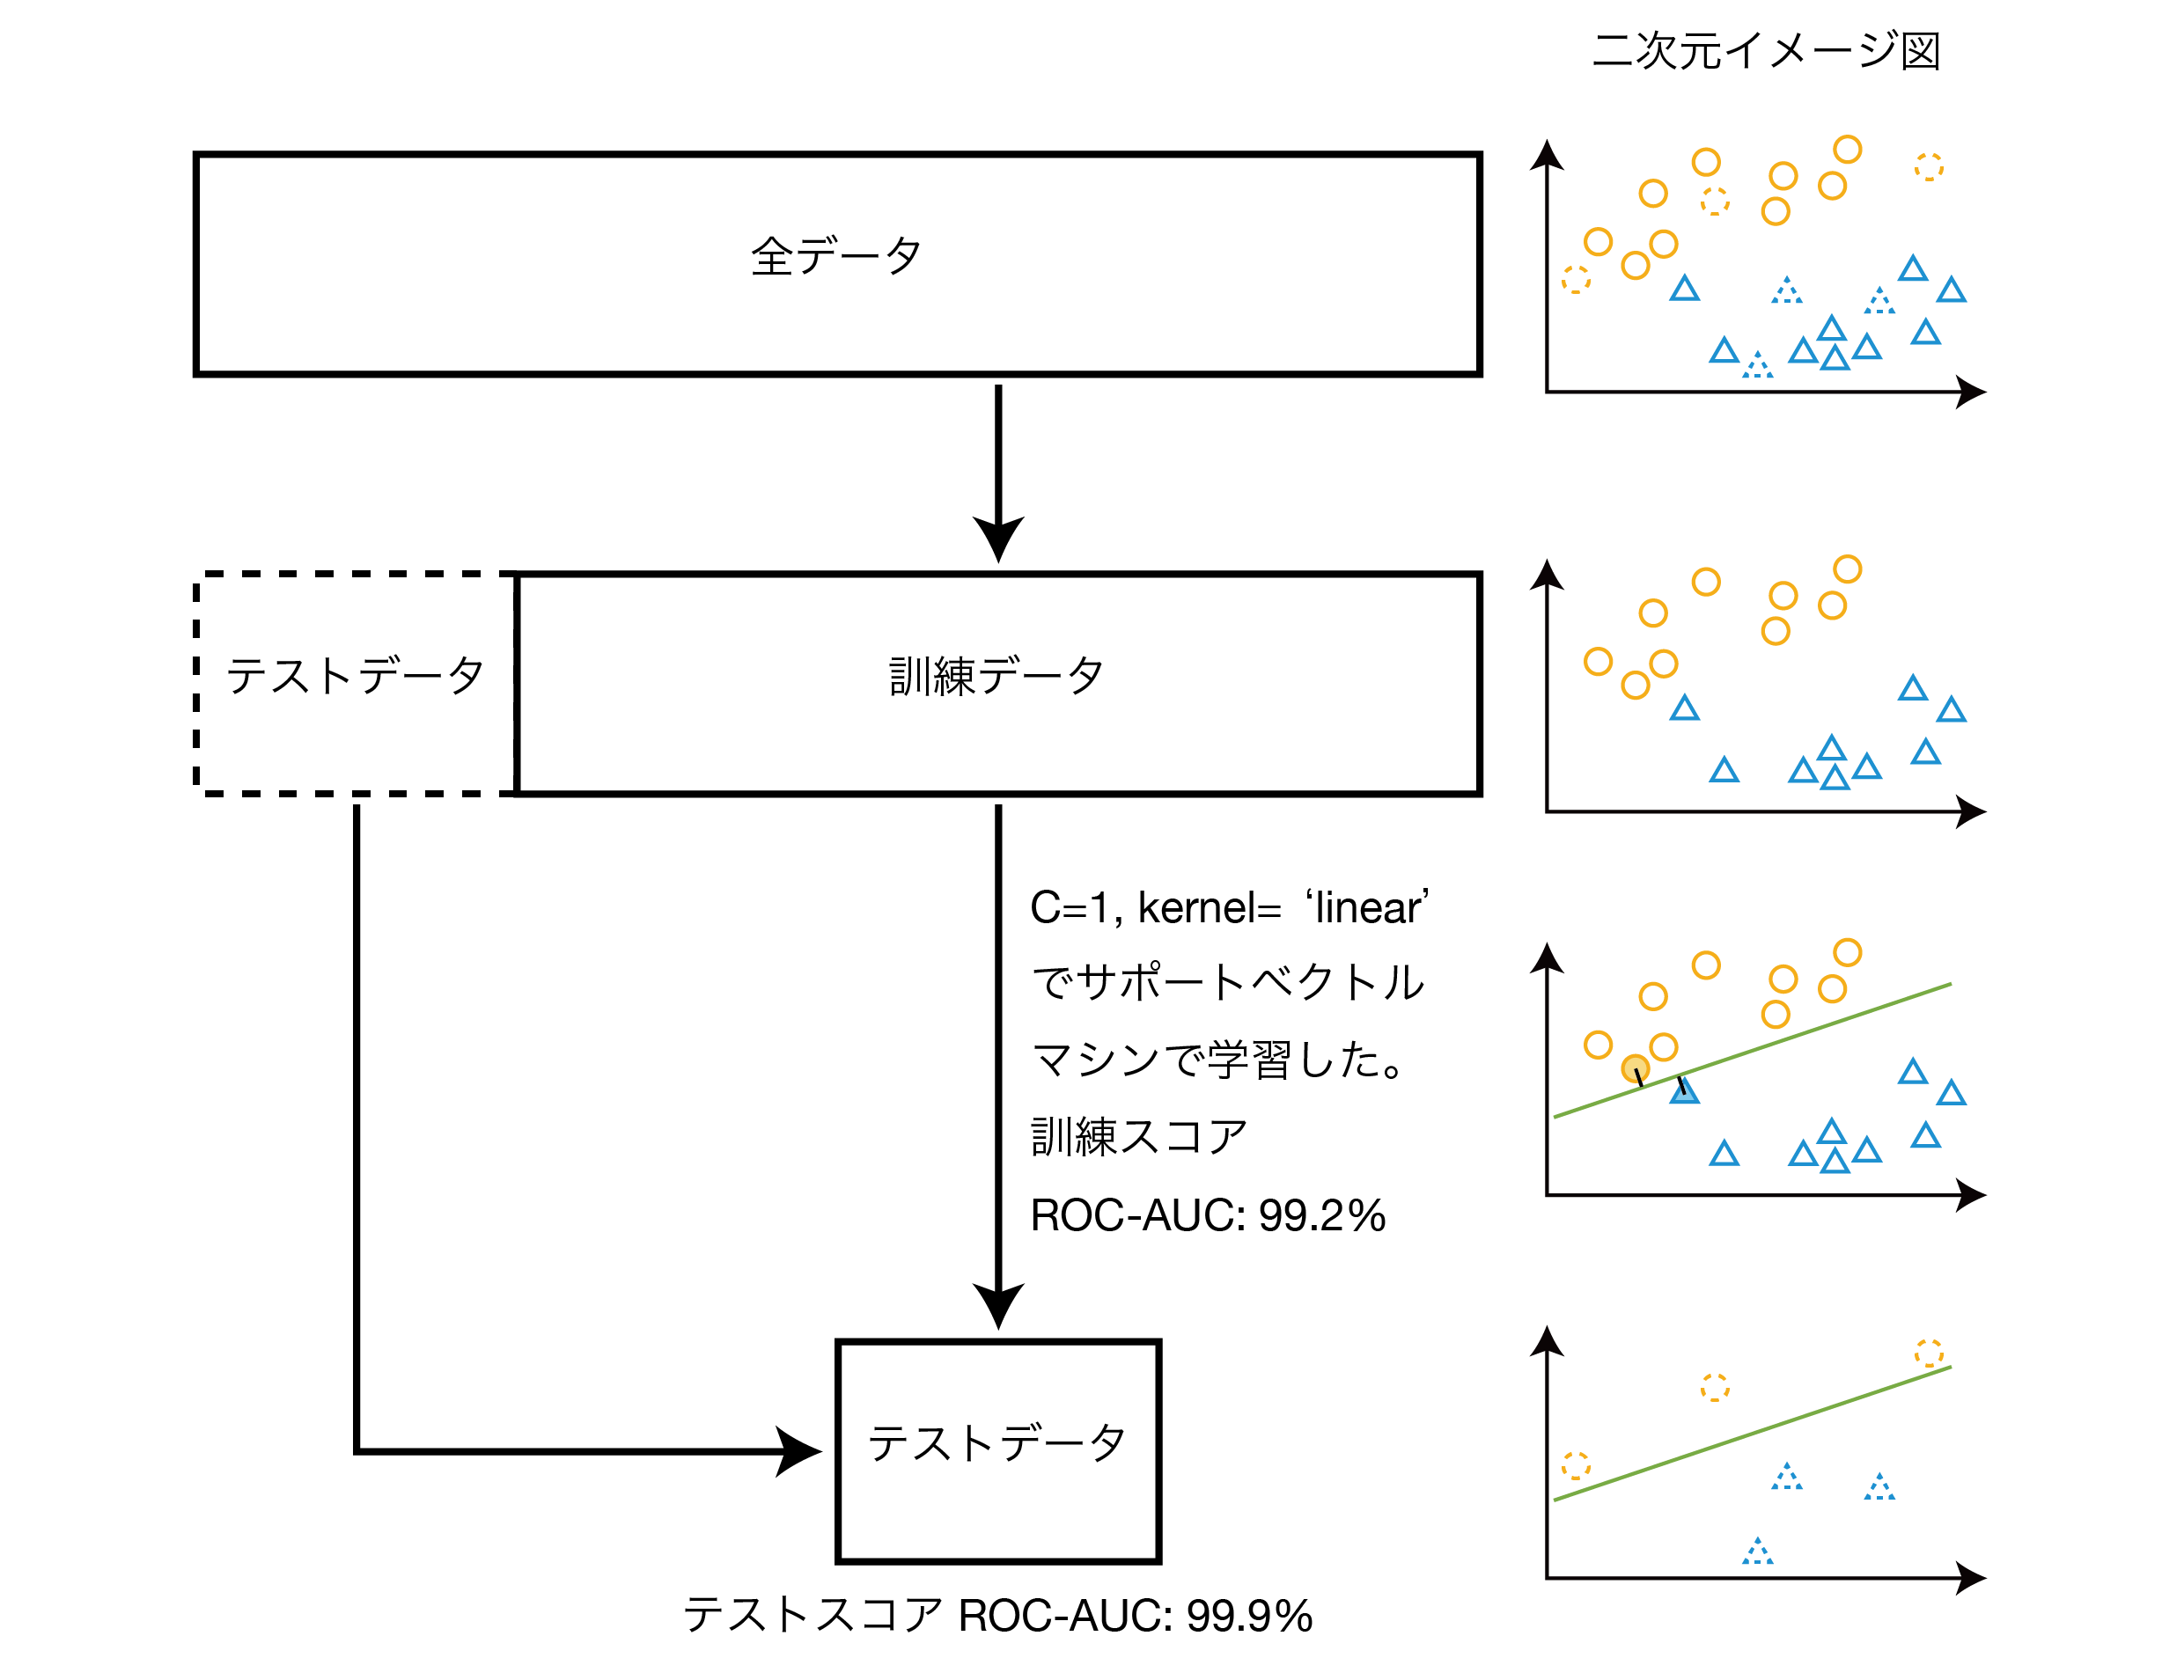

## 2-2. グリッドサーチによるハイパーパラメータの調整
前のセクションで構築した分類器の性能をさらに改善することを目指す。具体的には、検証データセットを導入し、交差検証法とグリッドサーチによるハイパーパラメータの最適化を行う。

前のセクションで構築した分類器は、ハイパーパラメータ調節をせずとも既に良い性能を示すと考えられるが、さらに改善するために2つの案を挙げよう。

*   ハイパーパラメータの良し悪しを考えるために、テストデータセットを使わずに**検証データセット**を用意する。元々の全データセットを、訓練データセット、検証データセット、テストデータセットの3つに分け、訓練結果を検証データで確認し、良い結果をテストデータで評価するのである。また、この考えをあと少し押し進めて、**交差検証**を導入しよう。
*   ハイパーパラメータを`kernel = 'linear'`, `C = 1`, `gamma = 1`と設定したが、その**最適化**を行なっていない。今回は、ハイパーパラメータの調節をせずとも良いスコア (99%) を出しているが、本来最適なハイパーパラメータを決定する際には、**グリッドサーチ**などの最適化手法を用いるものである。ここでは、グリッドサーチによるハイパーパラメータの調整も追加しよう。


---
**補足**

今回はまず機械学習の雰囲気を味わうという目的があったため、すぐにテストデータセットを使った。ただ、テストデータセットで計算した後、「スコアが良くないな。訓練からやり直すか」というのは、基本的にはよろしくない。例えば、「受験前勉強して、受験したけど不合格だったから受験前に時間を戻そう」というような行為であり、不適切である。テストデータセットは「二度漬け禁止」であり、テストデータセットを使わずにハイパーパラメータの良し悪しを考えるために検証データセットを用意している。

検証データセットは、グリッドサーチで最もスコアの良いものを選択するときに使われる。訓練データの学習が普段の勉強、テストデータでの確認が受験だとしたら、検証データセットは模擬試験だろう。訓練データセットで勉強したのはいいが、すぐにテストデータで受験すると失敗した時のリスクが大きい。そこで、模擬試験たる検証データセットで受験に受かりそうか否かを判断するのである。模擬試験で成績の悪いまま受験に行くのは良くない。

サポートベクトルマシンで分類を行うためには、決定境界の境界線を引く必要がある。具体例の図では、○と△は直線で線形分離可能だったが、実際のデータではそうでないケースが多い。**RBFカーネル**は、線形分離不可能なデータに対しサポートベクトルマシンを適用するための手法の一つとして用いられている。興味がある人は詳しく勉強してみてほしい。

最善や最大などと言わず、「最適」という言葉を使うのは「他により良いスコアを出すハイパーパラメータがあるかもしれないが、自分の努力した範囲内で最もスコアが良かった」という、ある種の妥協や謙虚さから生まれている。

---


**検証データセットの導入**

検証データセットの導入と言えども、元々のデータの分割に使っていた`sklearn.model_selection`モジュールの`train_test_split`関数をもう一度使うだけで良い。

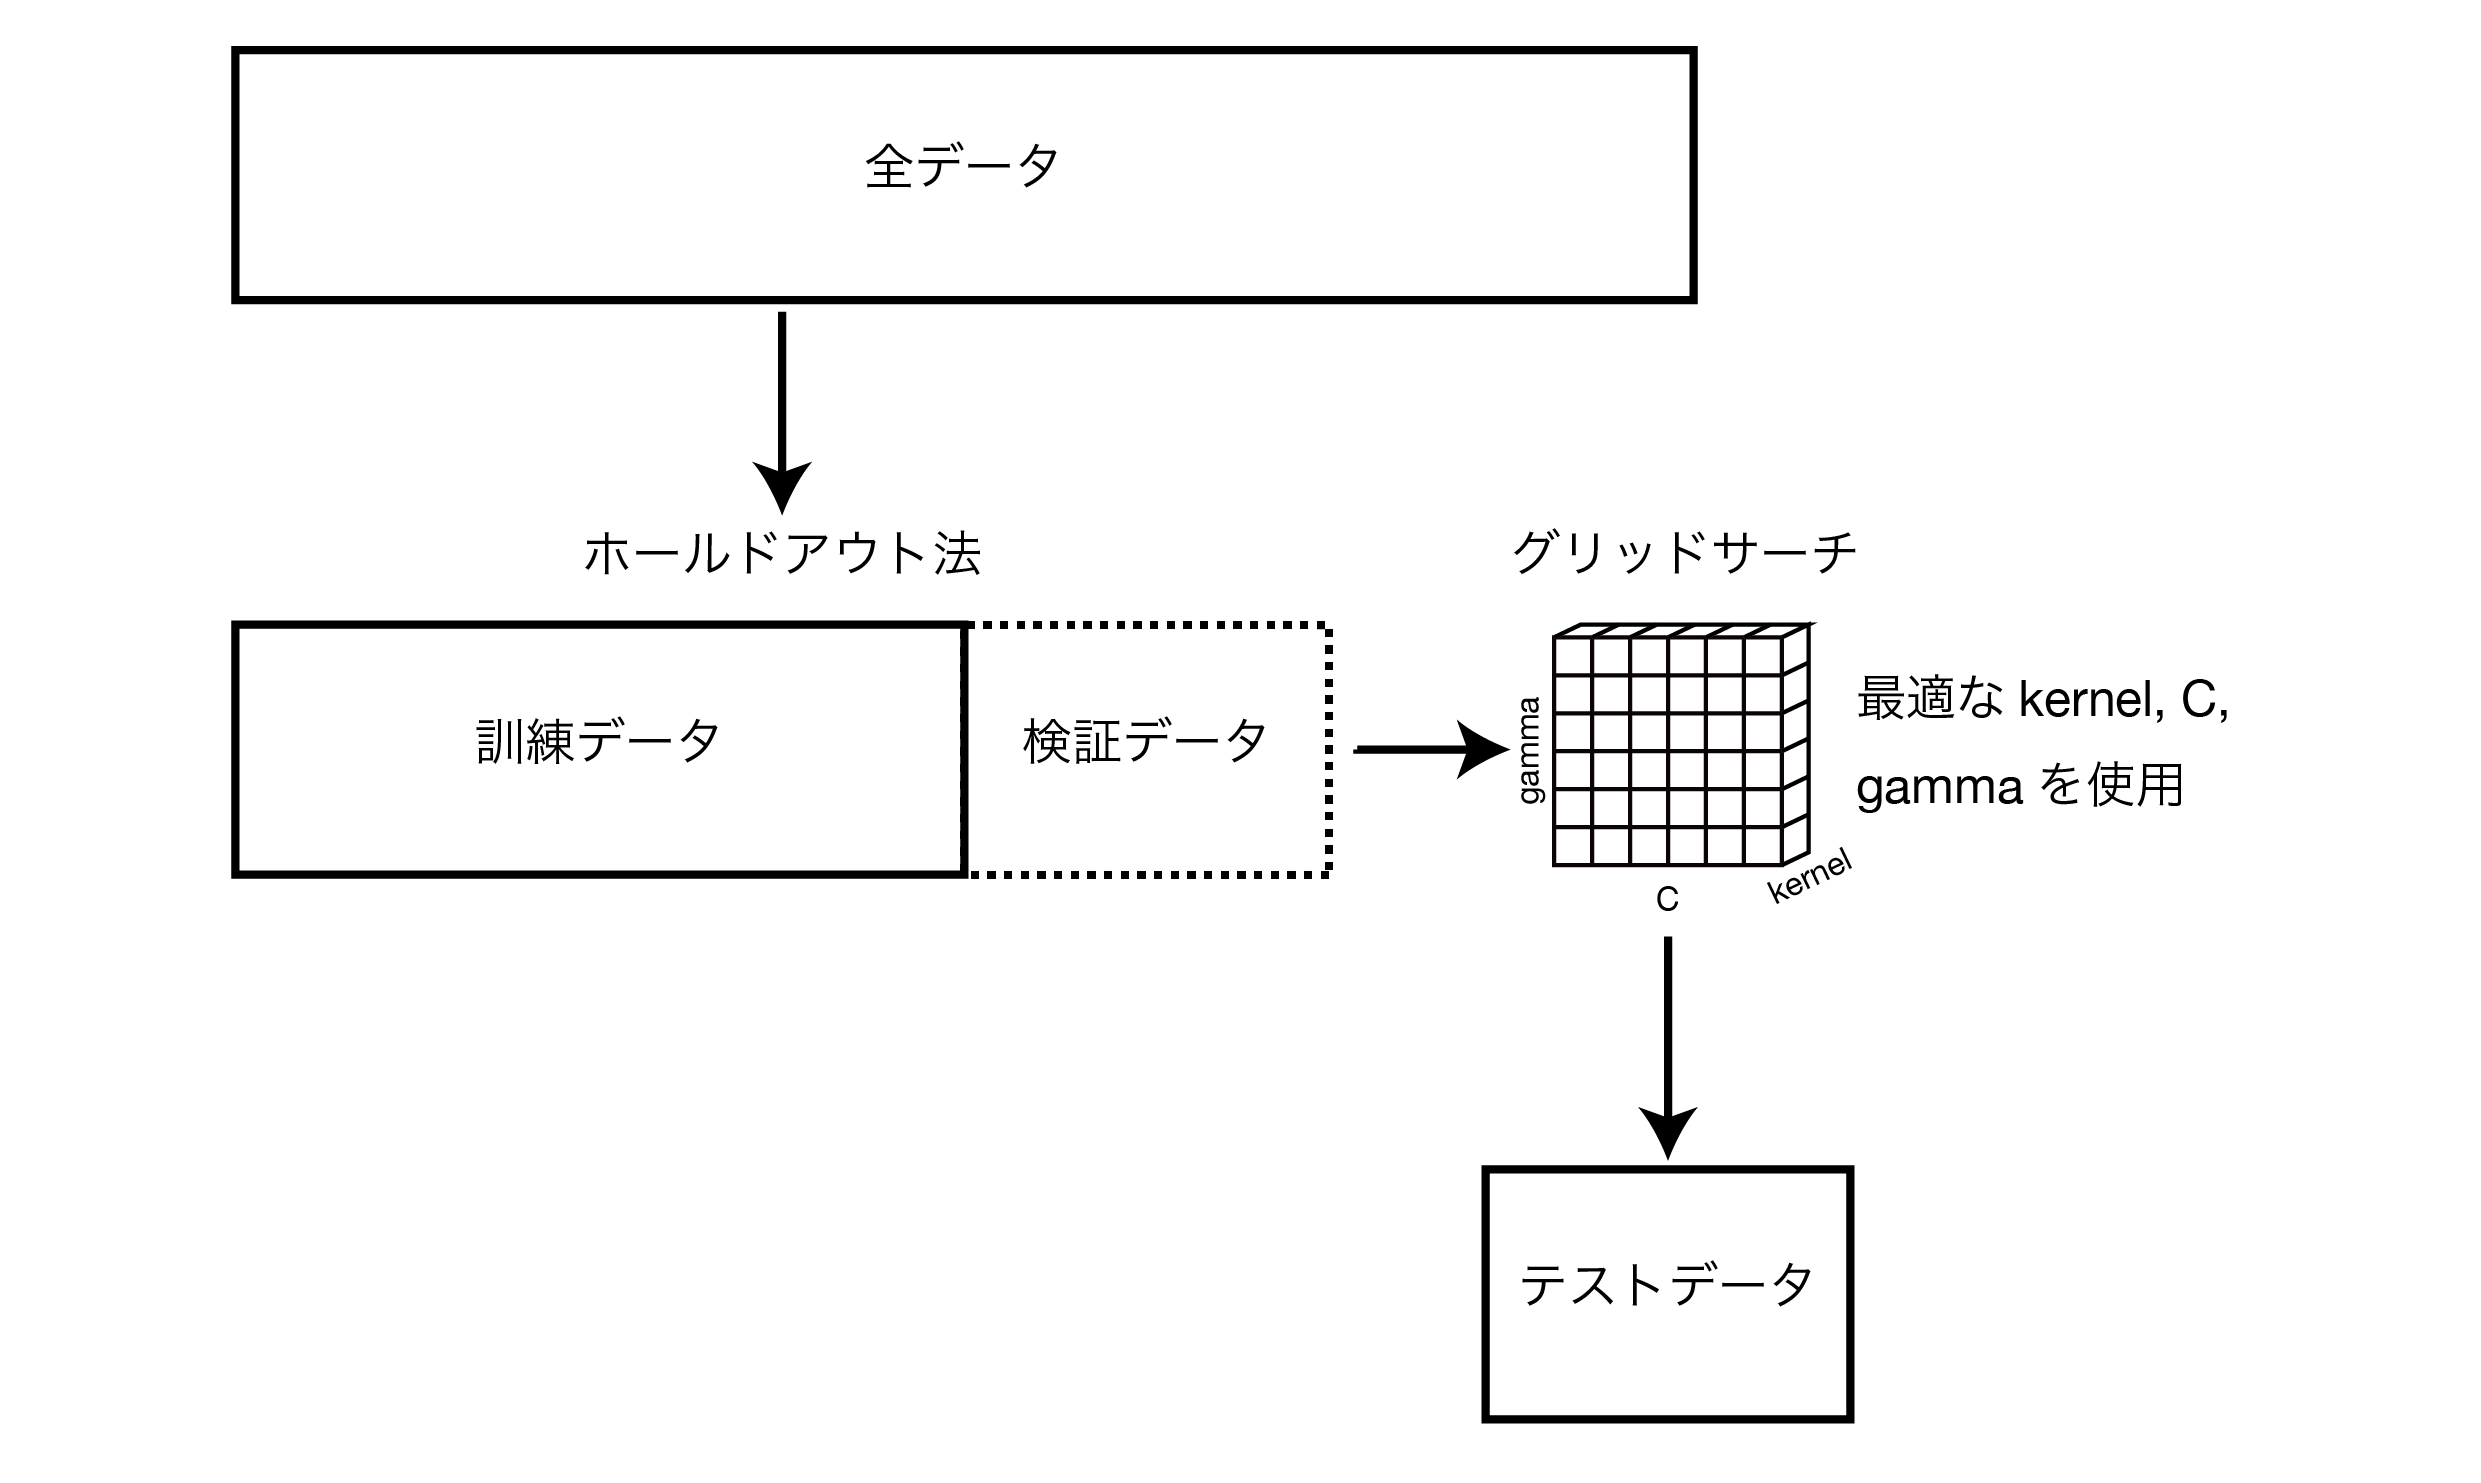

このように、訓練データセットから検証データセットを一つ用意して、それを参考にハイパーパラメータの最適化を行う。この手法を**ホールドアウト検証**という。以下に、ホールドアウト検証で検証データセットとグリッドサーチを実装したコードを示す。

まずは検証データセットを作成する。

In [ ]:
# 2-2-1 trainデータ、validationデータ、testデータを作り出す
from sklearn.model_selection import train_test_split

# 転置したものをtrain_test_split関数でtrainvalデータセット (全体の75％) とtestデータ (全体の25％) に分ける
gse_mRNA_exprs_normal_selected_trainval, gse_mRNA_exprs_normal_selected_test = train_test_split(gse_mRNA_exprs_normal_selected.T, train_size = 0.75, random_state = 0)
gse_mRNA_exprs_tumor_selected_trainval, gse_mRNA_exprs_tumor_selected_test = train_test_split(gse_mRNA_exprs_tumor_selected.T, train_size = 0.75, random_state = 0)

# 次にtrainvalデータセットをtrain (全体の50%) とval (全体の25%) に分ける
gse_mRNA_exprs_normal_selected_train, gse_mRNA_exprs_normal_selected_val = train_test_split(gse_mRNA_exprs_normal_selected_trainval, train_size = 0.667, random_state = 0)
gse_mRNA_exprs_tumor_selected_train, gse_mRNA_exprs_tumor_selected_val = train_test_split(gse_mRNA_exprs_tumor_selected_trainval, train_size = 0.667, random_state = 0)

# trainデータを作成
gse_mRNA_exprs_train = pd.concat([gse_mRNA_exprs_normal_selected_train, gse_mRNA_exprs_tumor_selected_train])
X_train = gse_mRNA_exprs_train.iloc[:, 0:-1]
y_train = gse_mRNA_exprs_train.iloc[:, -1]

# validationデータを作成
gse_mRNA_exprs_val = pd.concat([gse_mRNA_exprs_normal_selected_val, gse_mRNA_exprs_tumor_selected_val])
X_val = gse_mRNA_exprs_val.iloc[:, 0:-1]
y_val = gse_mRNA_exprs_val.iloc[:, -1]

# testデータを作成
gse_mRNA_exprs_test = pd.concat([gse_mRNA_exprs_normal_selected_test, gse_mRNA_exprs_tumor_selected_test])
X_test = gse_mRNA_exprs_test.iloc[:, 0:-1]
y_test = gse_mRNA_exprs_test.iloc[:, -1]


訓練データセットで、訓練データセット・検証データセット・テストデータセットを標準化する。

In [ ]:
# 2-2-2 標準化を行う
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

**グリッドサーチによるハイパーパラメータの最適化**

今回のグリッドサーチでは、以下のようなグリッドの全ての頂点について機械学習を行い、最もスコアの良かったものを選択する。

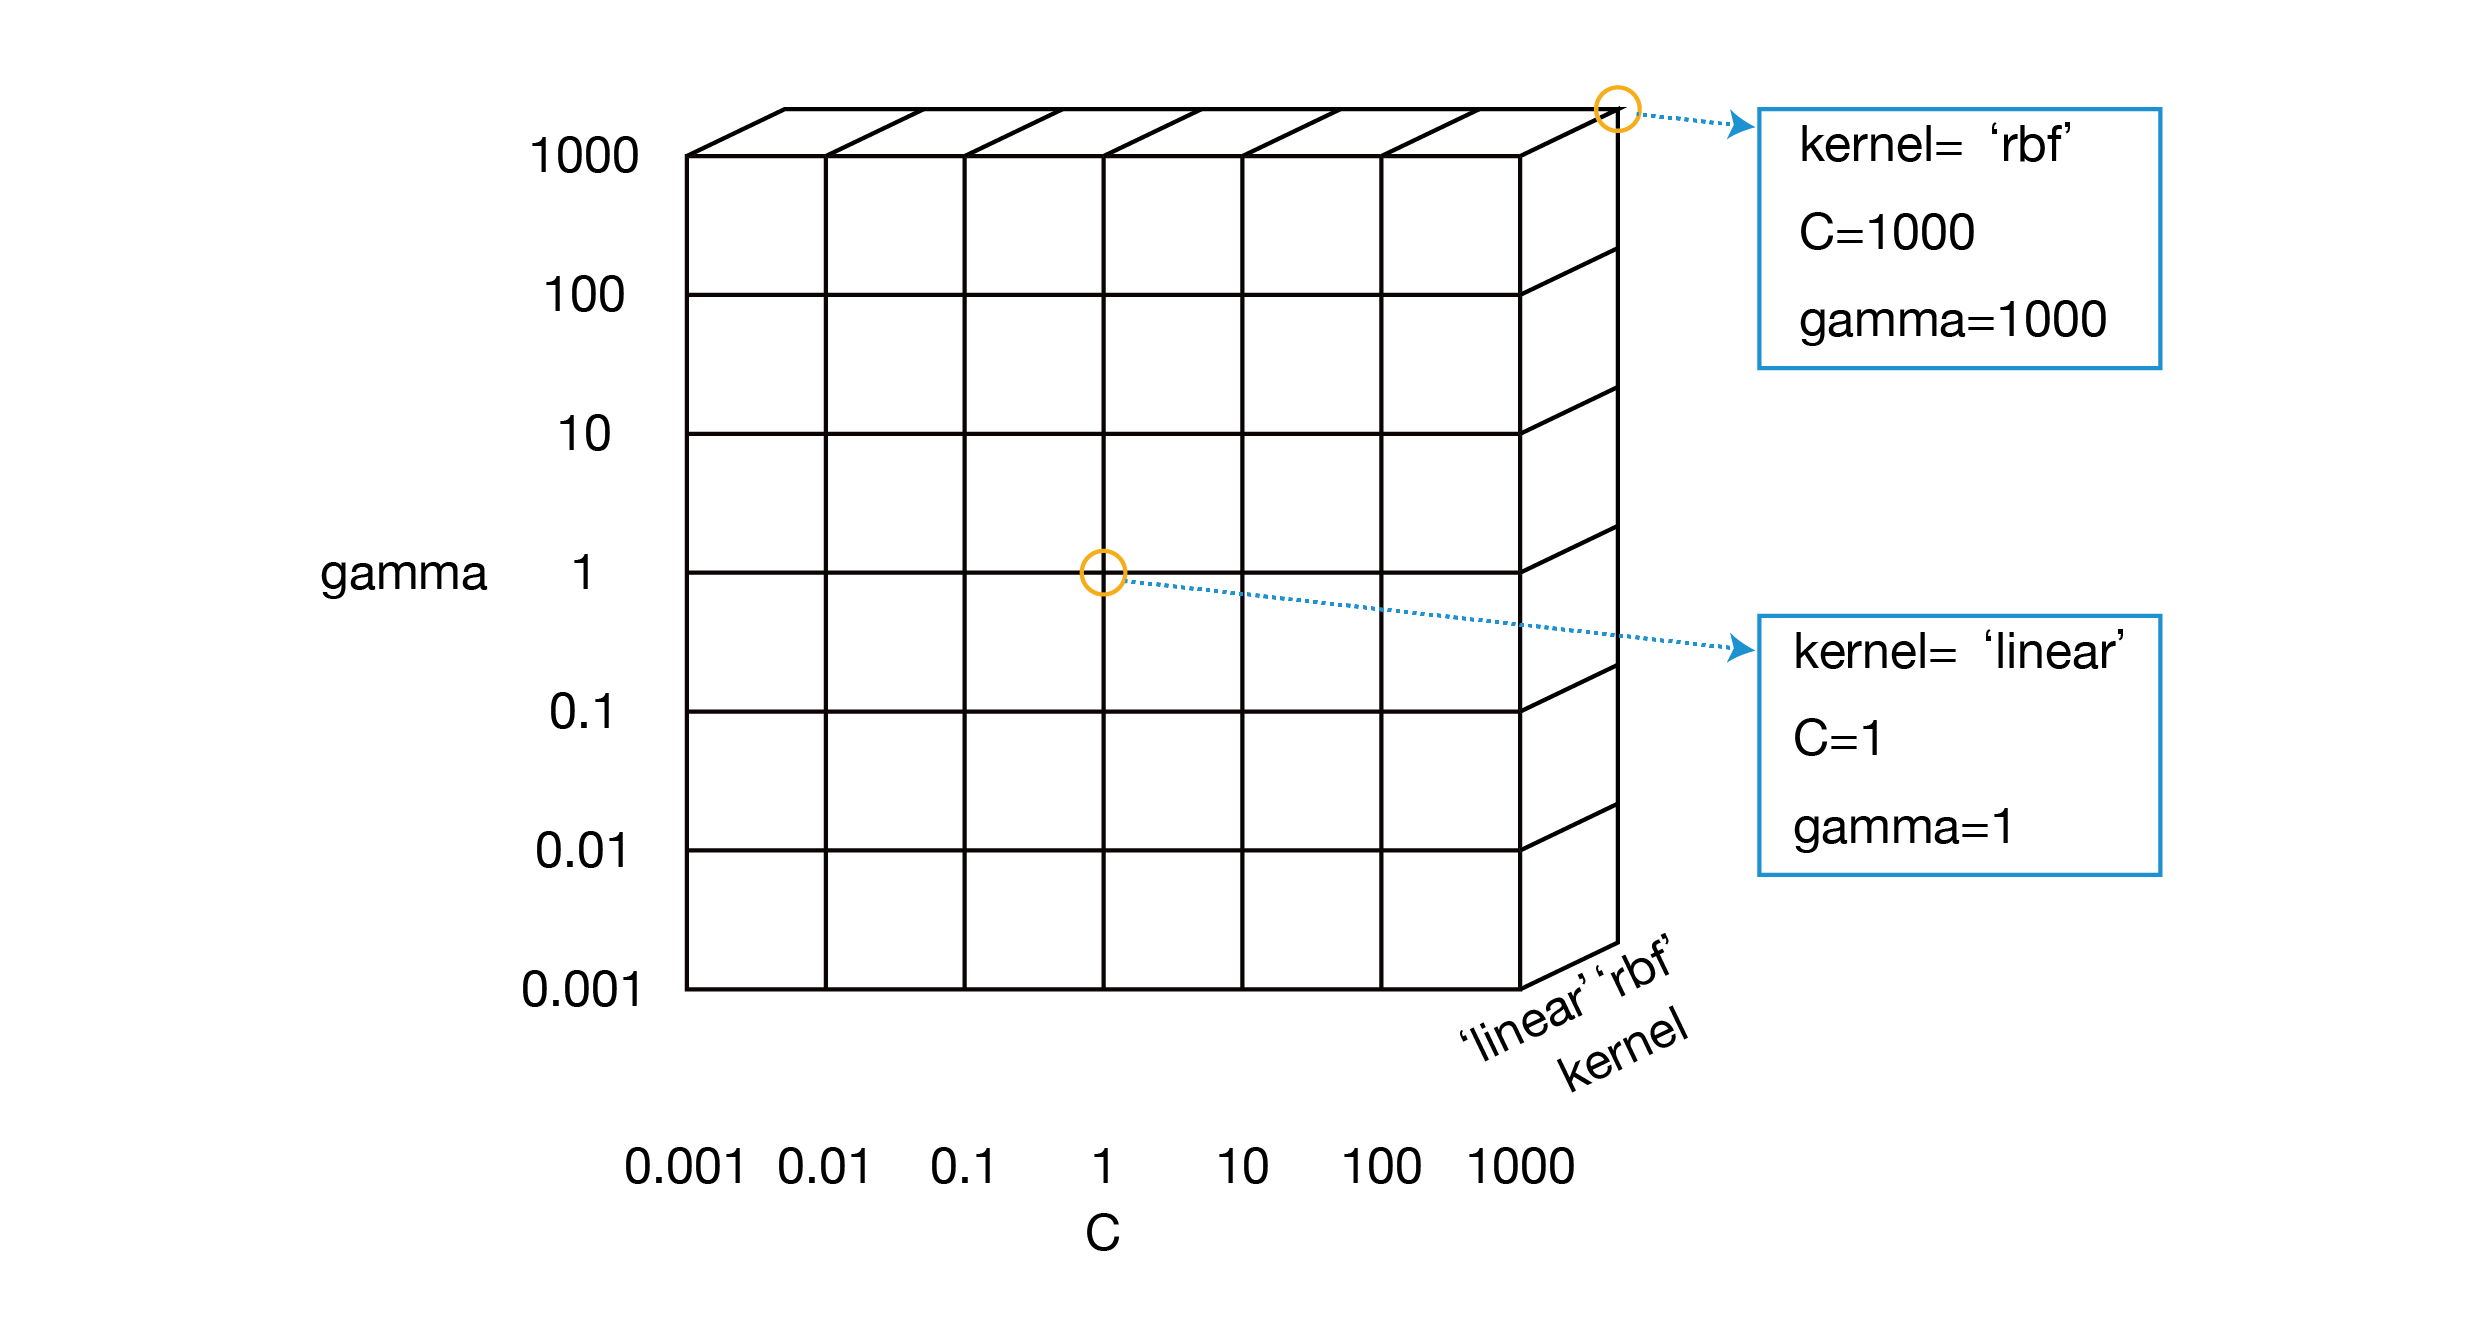

kernelは、`'linear'`と`'rbf'`の2通り、Cは、0.001, 0.01, 0.1, 1, 10, 100, 1000の7通り、gammaは、0.001, 0.01, 0.1, 1, 10, 100, 1000の7通りである。合計で98通りのモデルを比較して、最もスコアの良いものを探す。

グリッドサーチを実装するために、for文を用意した。これにより全てのハイパーパラメータの組み合わせで学習し、最もスコア (ROC-AUC) が大きいものを選ぶことができる。

In [ ]:
# 2-2-3 グリッドサーチの実行
kernel = ['linear', 'rbf']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# 当面の最高スコアを0としておいてあとで更新していく
best_score = 0

# グリッドサーチの実装のためにfor文を積み重ねる
for i in kernel:
    for j in C:
        for k in gamma:
            clf = SVC(kernel = i, C = j, gamma = k, random_state = 0, probability = True)
            clf.fit(X_train_std, y_train)
            y_val_pred = clf.predict_proba(X_val_std)[:, 1]
            gs_score = roc_auc_score(y_val, y_val_pred)

            # ハイパーパラメータやスコアの中身を詳しく見たい場合、以下コードの#を外して確認できる
            # print('kernel: {}'.format(i), 'C: {}'.format(j), 'gamma: {}'.format(k))
            # print('score: {}'.format(gs_score))

            # gs_scoreが現在のbest_scoreを超えた場合、best_scoreとbest_paramsを更新する
            if gs_score > best_score:
                best_score = gs_score
                best_params = {'kernel': i, 'C': j, 'gamma': k}

In [ ]:
# 2-2-4 結果の確認
print(best_score)
print(best_params)

このハイパーパラメータでモデルをテストデータセットに適用し、結果を確認する。

In [ ]:
# 2-2-5 これをテストデータセットに適用する
from sklearn.metrics import roc_auc_score
clf = SVC(**best_params, random_state = 0, probability = True)
clf.fit(X_train_std, y_train)
y_pred = clf.predict_proba(X_test_std)[:, 1]
test_score = roc_auc_score(y_test, y_pred)
print(test_score)

In [ ]:
# 2-2-6 ROC曲線
from sklearn.metrics import auc, roc_curve

# ROC-AUCを計算
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)

# plotを作成
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr_test, tpr_test, label = 'GridSearch+SVM (AUC = %.3f)' % auc_test)
plt.fill_between(fpr_test, tpr_test, 0, alpha = 0.1)
plt.legend()
plt.title('GridSearch+SVM')
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.grid(True)
plt.show()

In [ ]:
# 2-2-7 混同行列とclassification_report
from sklearn.metrics import classification_report, confusion_matrix
y_pred_label = [1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))]
print(confusion_matrix(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))

ROC-AUCは1.000、混同行列は$\begin{bmatrix}
49 & 0 \\
5 & 55 \\
\end{bmatrix}
$、accuracyは0.95となった。

**交差検証法によるハイパーパラメータの調整**

ホールドアウト検証の欠点は、用意した唯一の検証データセットが分布を代表するようなものではなく、外れ値ばかりで構成されている場合に結果が歪む点である。その問題を回避するために、検証データセットを複数個 (K個) 用意しようというのが、**K分割交差検証**の基本的なアイデアである。

これは訓練データをK分割して、そのうち一つを検証データセットに、残りを訓練データセットとして扱い、検証データセットで結果を確認する、という作業をK回行う。その平均を取って、最もスコアが良かったものを選ぶのである。以下に、3分割交差検証の図を示した。

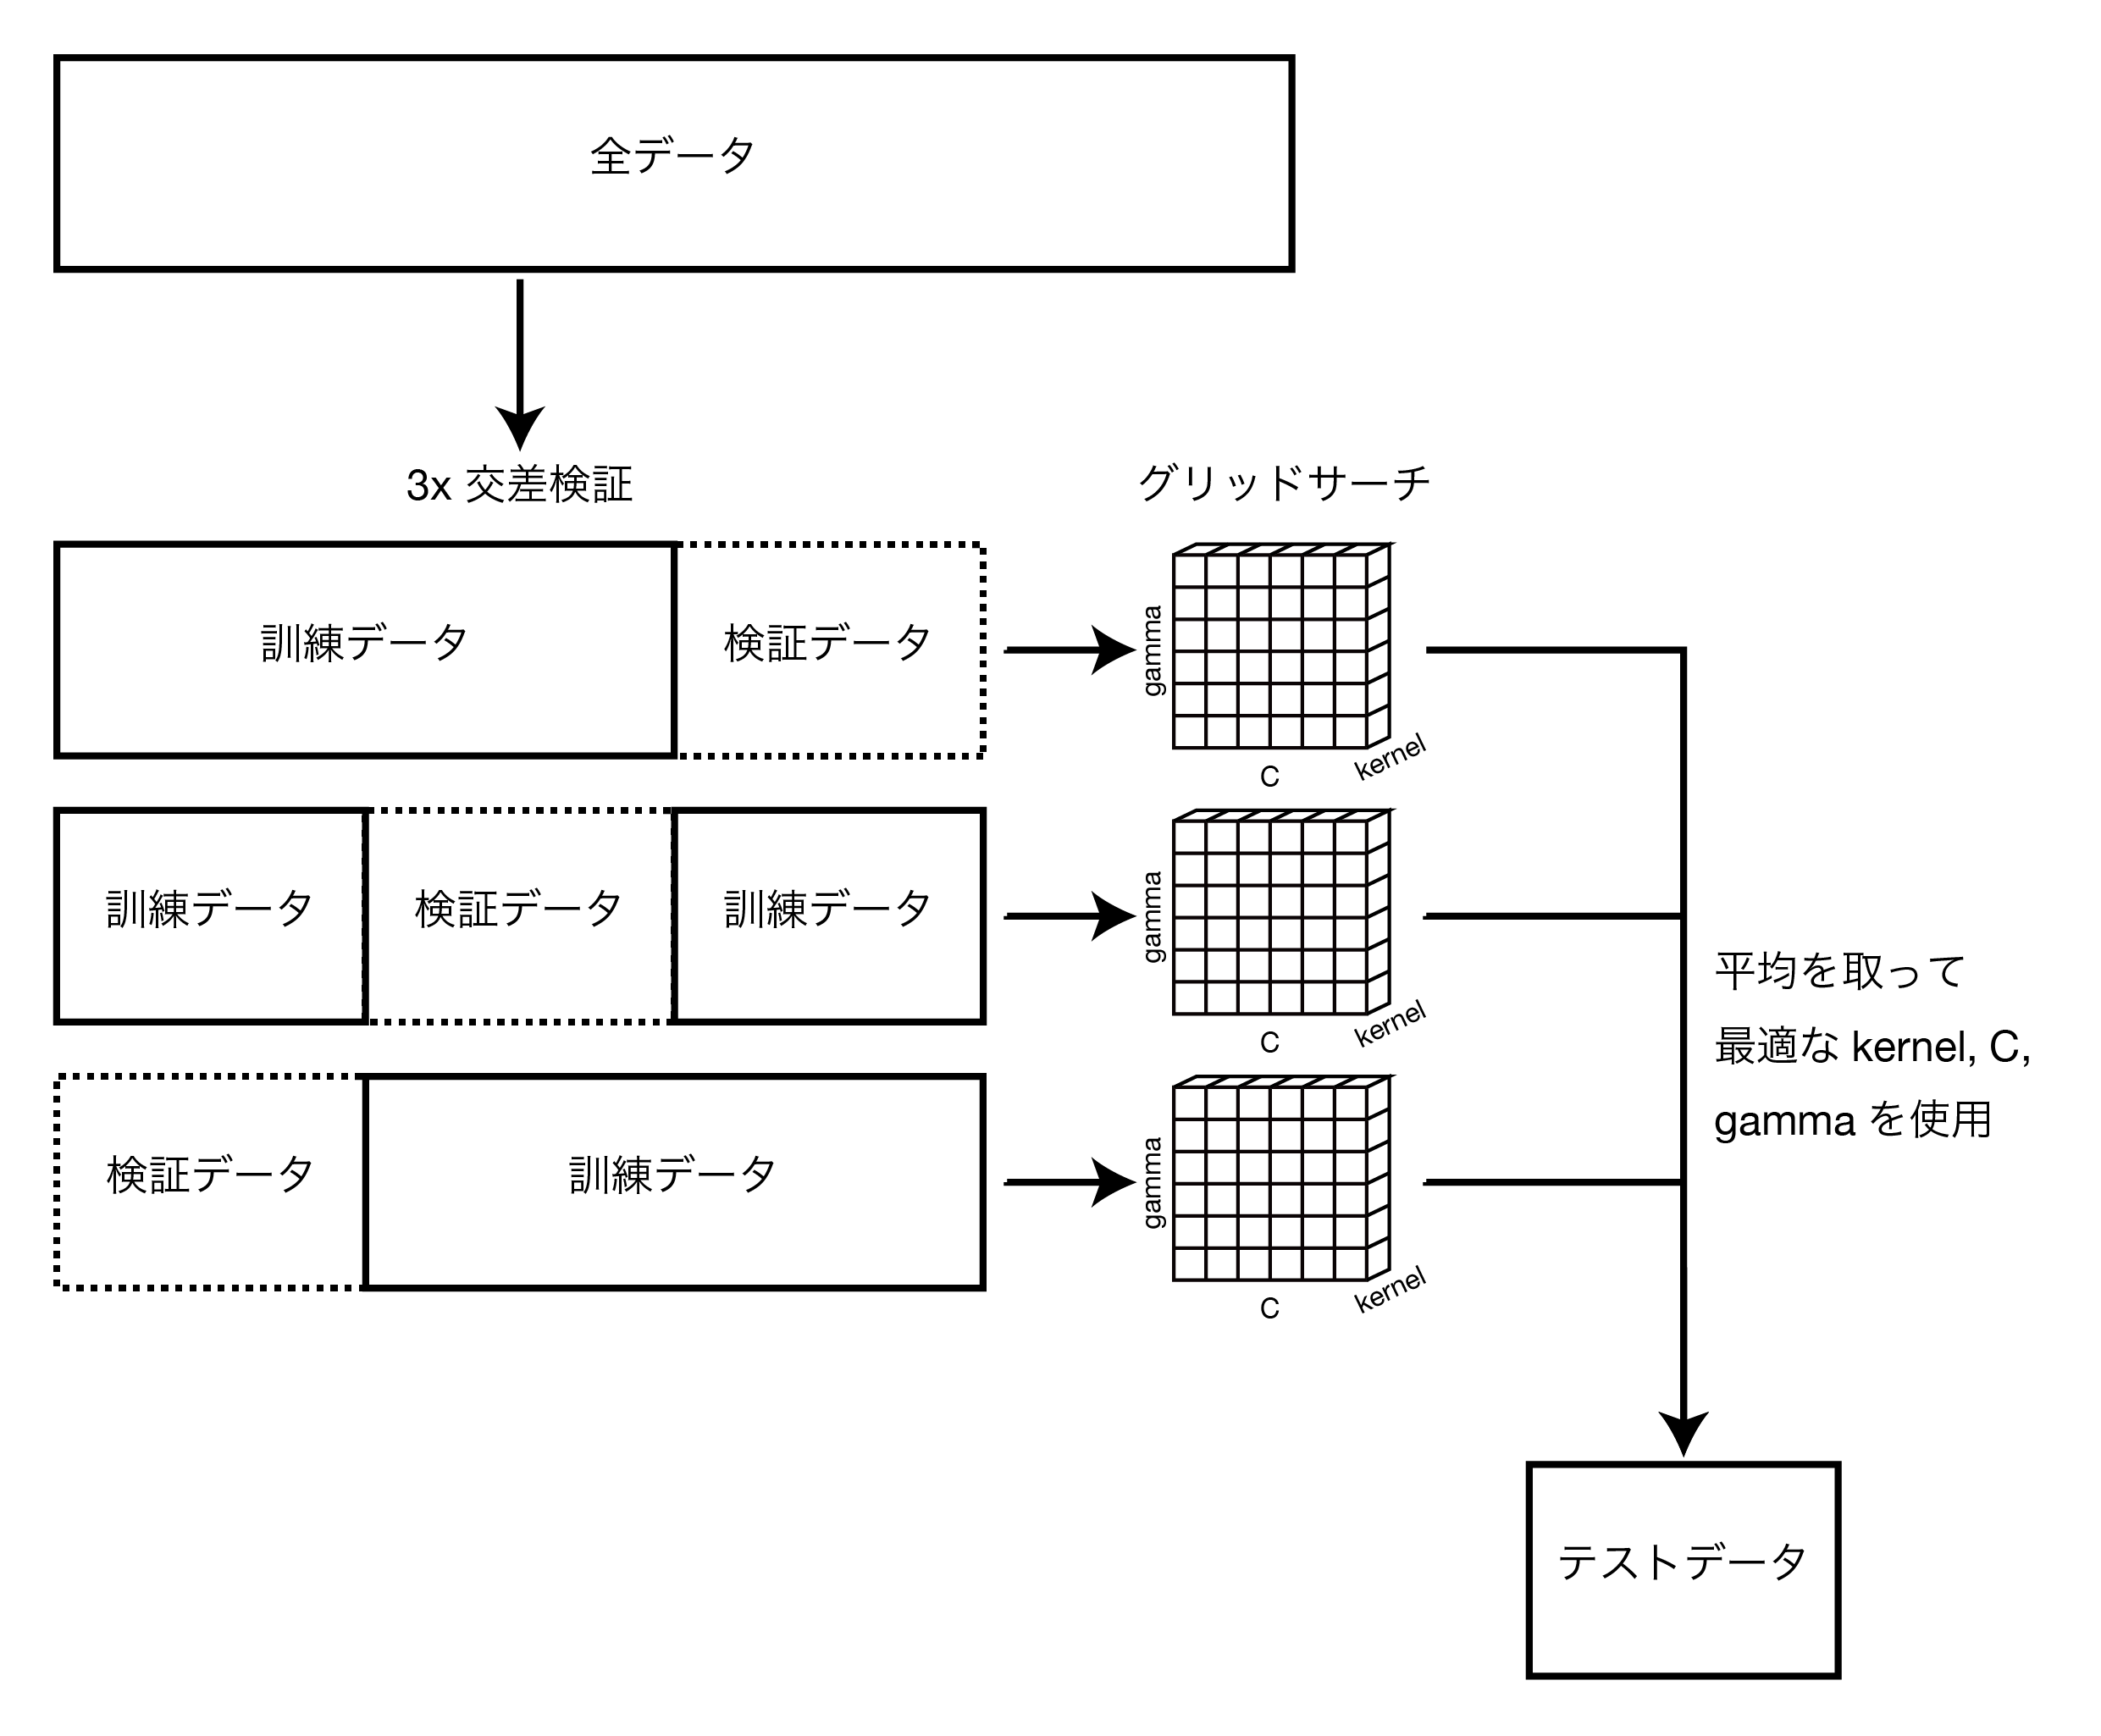

また、グリッドサーチは上のようなfor文を重ねた実装よりも、`sklearn.model_selection`の`GridSearchCV`クラスを使うことが多い。ここでCVとあるが、これが交差検証 (cross-validation) のことである。交差検証とグリッドサーチを同時に扱えるので便利な関数である。

In [ ]:
# 2-2-8 GridSearchCVでより良い検証ができる
from sklearn.model_selection import GridSearchCV

hyperparameters_gs = {
    'kernel': ['linear', 'rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'random_state': [0],
    'probability': [True],
}

# K分割交差検証の「分割」の部分 (KFoldではなく、StratifiedKFoldを使うことでNormalとTumorの比率を揃えたまま分割できる)
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

grid_search = GridSearchCV(SVC(), param_grid = hyperparameters_gs, cv = skf, scoring = 'f1')
grid_search.fit(X_train_std, y_train)

In [ ]:
# 2-2-9 最良の結果を表示
grid_search.best_score_

In [ ]:
# 2-2-10 最良のパラメータを表示
model = grid_search.best_estimator_
model

In [ ]:
# 2-2-11 最良のパラメータを用いて性能を評価
y_pred = model.predict_proba(X_test_std)[:, 1]
score = roc_auc_score(y_test, y_pred)
score

In [ ]:
# 2-2-12 ROC曲線
from sklearn.metrics import auc, roc_curve

# ROC-AUCを計算
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)

# plotを作成
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr_test, tpr_test, label = 'GridSearchCV+SVM (AUC = %.3f)' % auc_test)
plt.fill_between(fpr_test, tpr_test, 0, alpha = 0.1)
plt.legend()
plt.title('GridSearchCV+SVM')
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.grid(True)
plt.show()

In [ ]:
# 2-2-13 混同行列とclassification_report
from sklearn.metrics import classification_report, confusion_matrix
y_pred_label = [1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))]
print(confusion_matrix(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))

## 2-3. ベイズ最適化によるハイパーパラメータの調整
最後にグリッドサーチとは別の最適化手法の一つを解説しておこう。それが**ベイズ最適化**である。

グリッドサーチはあくまでも、手動でパラメータを振って最も良い点を探させた方法で、言うなればキリの良い数字だけで実験しただけである。今回の例ではハイパーパラメータは3種類、高々98通りの実験だったのでそれほど時間もかかっていないが、より難しい機械学習モデルの最適化において、多すぎるハイパーパラメータに対し総あたりしていくと相応の時間がかかる。また、グリッドサーチではハイパーパラメータの値を指定しなければならないが、適切な値を指定するには、ある種職人的な経験と勘を必要とする部分がある。

一方、ベイズ最適化は自動で試行錯誤しながら、より優れたハイパーパラメータを推定し探し出すことができる。ハイパーパラメータも、数値データなら数値の最小値と最大値で探索範囲を指定するだけで良いため、職人的な負担も少ない。ハイパーパラメータの最適化ではより賢い方法だろう。

ハイパーパラメータのベイズ最適化ライブラリとして、**optuna**や**Ray Tune**などがあるが、ここではoptunaを利用する。これはPreferred Networks (PFN) 社の開発したハイパーパラメータの自動最適化フレームワークである。Ray Tuneと比較して日本製だけあって日本語の資料が充実しているため、最初に学ぶベイズ最適化手法としてふさわしいだろう。昨年9月2日にバージョン4へアップグレードされ、応用範囲も広がっている。ここでoptunaの基本を押さえておくことには価値がある。

Optunaを使う上で重要なのは`objective`と`study`と`trial`の三つである。`objective`とは、最適化すべき目的関数である。ここでは、F値を最適化すべき目的関数とする。`study`は何回最適化するか、最適化の方向は最大化か最小化か (目的関数に損失関数を指定した場合最小化する) 、最適化の結果などと関わる。`trial`は最適化するハイパーパラメータの範囲を指定する。カテゴリカル変数は`trial.suggest_categorical`で、整数変数は`trial.suggest_int`で、通常の連続値は`trial.suggest_float`、対数的な連続値の取り方では`trial.suggest_float(log=True)`で設定する。また、例えば0.1, 0.2, 0.3, 0.4, 0.5などのように連続値ではあるが、離散的なとり方 (この場合は0.1から0.5まで0.1ずつ変動) をしたい場合、`trial.suggest_float(0.1, 0.5, step=0.1)`とする。

実例を見てみよう。ここでは、`kernel`は`'linear'`を使うか`'rbf'`を使うか、optunaに選ばせる。`C`や`gamma`も、範囲だけ決めてoptunaに選ばせる。

In [ ]:
# 2-3-1 Optunaを用いたサポートベクトルマシンのハイパーパラメータ最適化における関数を定義
from functools import partial
import optuna
from sklearn.model_selection import cross_val_score

# trialでハイパーパラメータの範囲を指定する
def objective_svc(trial):
    '''最適化すべき目的関数'''
    params_svc = {
        # 'kernel'はカテゴリカル変数 ('linear'か'rbf'かをoptunaに選ばせる)
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        # 'C'は連続値だが、対数的なとり方を行う (0.001から1000までの値をoptunaに選ばせる)
        'C': trial.suggest_float('C', 1e-3, 1e3, log = True),
        # 'gamma'も連続値だが、対数的なとり方を行う (0.001から1000までの値をoptunaに選ばせる)
        'gamma': trial.suggest_float('gamma', 1e-3, 1e3, log = True),
        'random_state': 0,
    }
    clf = SVC(**params_svc)
    skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

    # グリッドサーチとは別の最適化手法を用いるため、GridSearchCVクラスではなくcross_val_score関数で交差検証を行う
    train_scores = cross_val_score(clf, X_train_std, y_train, cv = skf, scoring = 'f1')
    metric = train_scores.mean()

    # return metricで最適化すべき目的関数をmetricに指定する
    return metric

In [ ]:
# 2-3-2 ハイパーパラメータ最適化の実行
obj_svc = partial(objective_svc)

# セッションの作成
sampler = optuna.samplers.TPESampler(seed = 0)

# F値を最大化するためにdirection = 'maximize'にする
study_svc = optuna.create_study(sampler = sampler, direction = 'maximize')

# 回数を指定する
study_svc.optimize(obj_svc, n_trials = 100)

In [ ]:
# 2-3-3 最適化した結果の確認
print(study_svc.best_params)
print(study_svc.best_value)

In [ ]:
# 2-3-4 データの確認
study_svc.trials_dataframe()

optunaで得られた最適解のテストデータセットでの結果を確認しよう。

In [ ]:
# 2-3-5 訓練データのスコア
optuna_params = study_svc.best_params
clf = SVC(**optuna_params, probability = True)
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
train_scores = cross_val_score(clf, X_train_std, y_train, cv = skf, scoring = 'f1')
metric = train_scores.mean()
print(metric)

In [ ]:
# 2-3-6 test scoreは？
from sklearn import metrics
clf.fit(X_train_std, y_train)
y_pred = clf.predict_proba(X_test_std)[:, 1]
roc_auc_score(y_test, y_pred)

In [ ]:
# 2-3-7 ROC曲線
from sklearn.metrics import auc, roc_curve

# ROC-AUCの計算
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)

# plotの作成
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr_test, tpr_test, label = 'Optuna+SVM (AUC = %.3f)' % auc_test)
plt.fill_between(fpr_test, tpr_test, 0, alpha = 0.1)
plt.legend()
plt.title('Optuna+SVM')
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.grid(True)
plt.show()

In [ ]:
# 2-3-8 混同行列とclassification_report
from sklearn.metrics import classification_report, confusion_matrix
y_pred_label = [1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))]
print(confusion_matrix(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))

**このセクションのまとめ**

先ほど準備したデータを`scikit-learn`ライブラリを用いて機械学習で分類した。ここまでで機械学習のワークフローを基本的な部分から幅広くカバーしたことになる。時間の都合上、サポートベクトルマシンの二値分類のみを扱ったが、他にもロジスティック回帰やランダムフォレスト、K近傍法、勾配ブースティング決定木など学ぶ価値のある機械学習アルゴリズムは多い。幅広いアルゴリズムを知っていれば幅広い問題に対応することが可能であり、また幅広いアルゴリズムそれぞれの出した結果を合わせて (アンサンブルという) より良い分類を行うこともできるだろう。ぜひ調べてみてほしい。

# 3. PyTorchを用いたトランスクリプトームデータの分類

**目的**

ここでは有用な深層学習ライブラリである`PyTorch`を利用して、ニューラルネットワークによる機械学習分類器を構築することを目標とする。その際、PyTorchの基本文法や深層学習についての基本知識を学ぶ。

**題材**

肝細胞がんの公共マイクロアレイデータセット (GSE36376) から抽出した、正常サンプルとがんサンプルで発現変動量が大きかった19555種類のヒトのmRNA発現量データ

**方法**

ここでは、まずニューラルネットワークによる肝細胞がんと隣接正常肝臓の分類を行う深層学習モデルを構築する。また、より良いモデルを目指してハイパーパラメータの調整を行う。

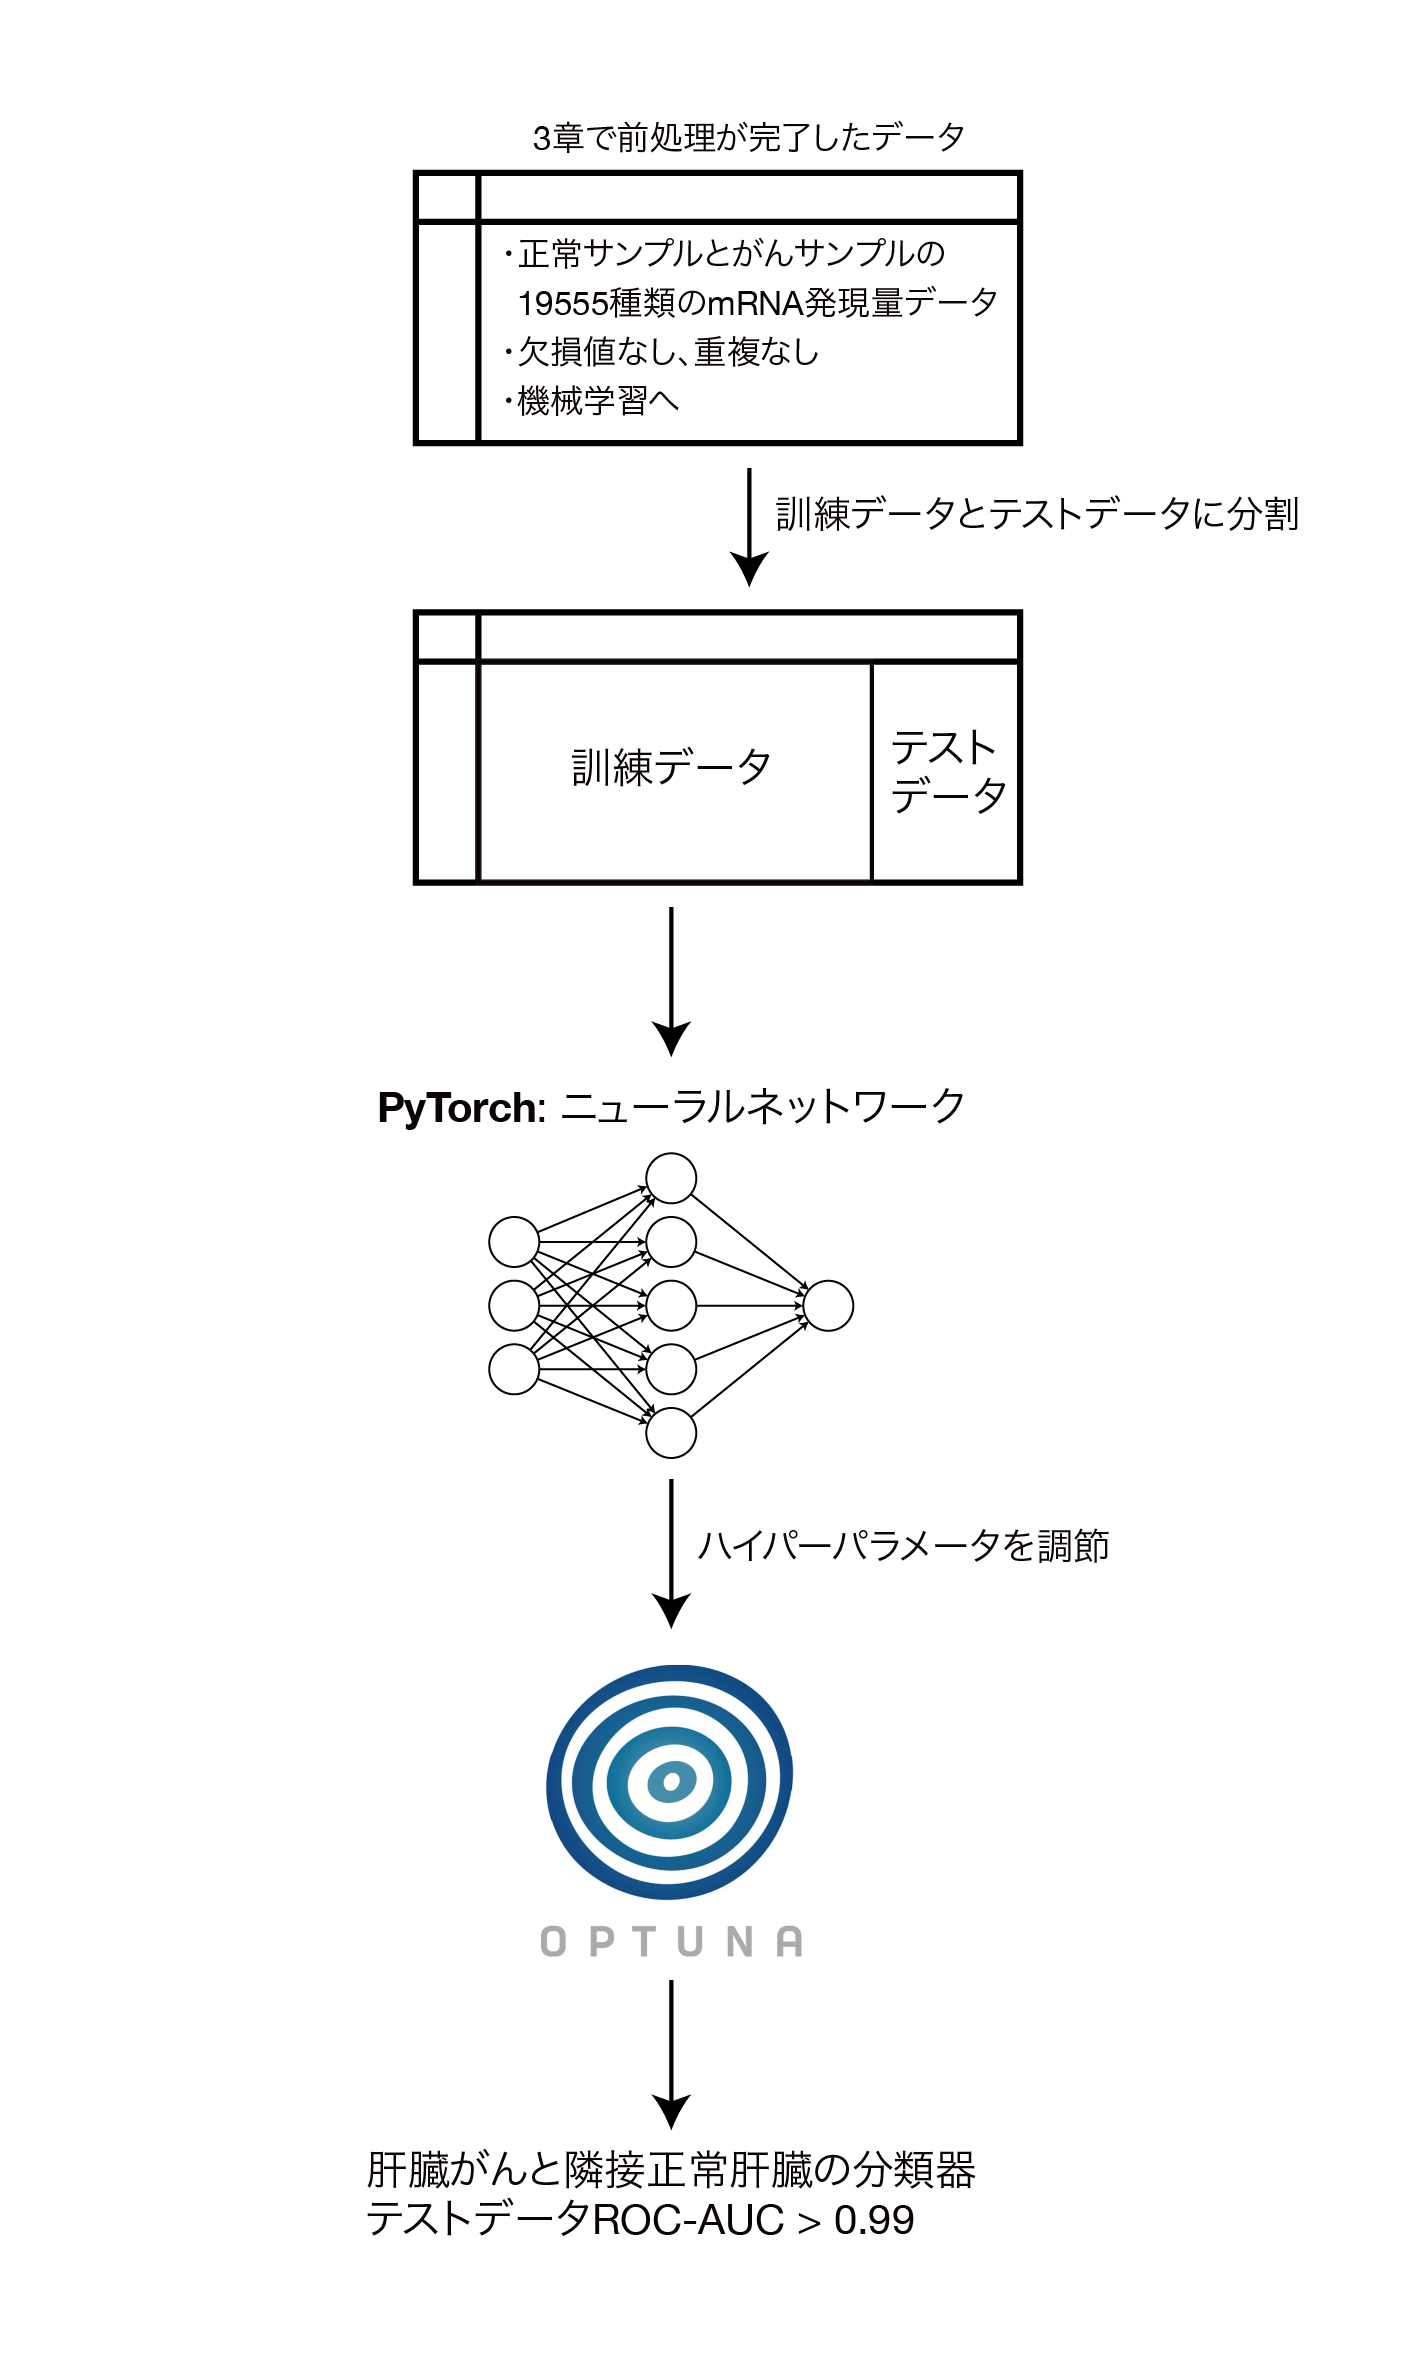

## 3-1. ニューラルネットワークの実装

最初に作成したデータを使用して、深層学習の一種であるニューラルネットワークモデルを実装する。具体的には、元のデータを訓練データ・検証データ・テストデータに分割して標準化を行ったのち、学習を行う。評価はROC曲線のAUCや混合行列によって行う。

今回はホールドアウト検証の用意をしておこう。データを訓練データ50%、検証データ25%、テストデータ25%に分け、訓練データセットで標準化する。

In [ ]:
# 3-1-1 分類器を作るために、データを分割
from sklearn.model_selection import train_test_split

# 転置したものをtrain_test_split関数でtrainvalデータセット (全体の75％) とtestデータ (全体の25％) に分ける
gse_mRNA_exprs_normal_selected_trainval, gse_mRNA_exprs_normal_selected_test = train_test_split(gse_mRNA_exprs_normal_selected.T, train_size = 0.75, random_state = 0)
gse_mRNA_exprs_tumor_selected_trainval, gse_mRNA_exprs_tumor_selected_test = train_test_split(gse_mRNA_exprs_tumor_selected.T, train_size = 0.75, random_state = 0)

# 次にtrainvalデータセットをtrain (全体の50%) とval (全体の25%) に分ける
gse_mRNA_exprs_normal_selected_train, gse_mRNA_exprs_normal_selected_val = train_test_split(gse_mRNA_exprs_normal_selected_trainval, train_size = 0.667, random_state = 0)
gse_mRNA_exprs_tumor_selected_train, gse_mRNA_exprs_tumor_selected_val = train_test_split(gse_mRNA_exprs_tumor_selected_trainval, train_size = 0.667, random_state = 0)

# trainデータを作成
gse_mRNA_exprs_train = pd.concat([gse_mRNA_exprs_normal_selected_train, gse_mRNA_exprs_tumor_selected_train])
X_train = gse_mRNA_exprs_train.iloc[:, 0:-1]
y_train = gse_mRNA_exprs_train.iloc[:, -1]

# validationデータを作成
gse_mRNA_exprs_val = pd.concat([gse_mRNA_exprs_normal_selected_val, gse_mRNA_exprs_tumor_selected_val])
X_val = gse_mRNA_exprs_val.iloc[:, 0:-1]
y_val = gse_mRNA_exprs_val.iloc[:, -1]

# testデータを作成
gse_mRNA_exprs_test = pd.concat([gse_mRNA_exprs_normal_selected_test, gse_mRNA_exprs_tumor_selected_test])
X_test = gse_mRNA_exprs_test.iloc[:, 0:-1]
y_test = gse_mRNA_exprs_test.iloc[:, -1]

# データの標準化
from sklearn.preprocessing import StandardScaler

# StandardScalerクラスのfitメソッドにより、トレーニングデータからデータ全体の平均値と標準偏差を推定
sc = StandardScaler()
sc.fit(X_train)

# トレーニングデータの平均と標準偏差の計算
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

また、深層学習では何も設定していないと結果に再現性が取れないことが多々あるため、再現性を保つためのコードを書いておく。

In [ ]:
# 3-1-2 コードに再現性をもたせるためにシードを固定
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

PyTorchを学ぶ上でまずはデータセットを扱うための基本文法を学ぶ。それが、`torch.utils.data`モジュールの`Dataset`クラスと`DataLoader`クラスである。

まずは`Dataset`クラスについて。ここには、サンプルデータとそれに対応するラベルが含まれる。自分で用意したデータセットを扱う際は、`__init__`、`__getitem__`、`__len__`という基本の三つの関数を用意しなければならない。`__init__`はデータセットの初期設定、`__getitem__`は指定されたindexに対応するサンプル、`__len__`はデータセットのサンプル数を読み込んで返す関数である。

In [ ]:
# 3-1-3 データセットの設定
from torch.utils.data import DataLoader, Dataset

# 訓練データ
class TrainData(Dataset):
    # データセットの初期設定
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    # 指定されたindexに対応するサンプルを取ってくる
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    # データセットのサンプル数
    def __len__(self):
        return len(self.X_data)

# y_trainをNumPy配列に変換してからtorch.FloatTensorに渡す
train_data = TrainData(torch.FloatTensor(X_train_std), torch.FloatTensor(y_train.values))

# 検証データ
class ValData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)

# y_valをNumPy配列に変換してからtorch.FloatTensorに渡す
val_data = ValData(torch.FloatTensor(X_val_std), torch.FloatTensor(y_val.values))

# テストデータ
class TestData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)

# y_testをNumPy配列に変換してからtorch.FloatTensorに渡す
test_data = TestData(torch.FloatTensor(X_test_std), torch.FloatTensor(y_test.values))

次に、`DataLoader`クラスについて。これは、`Dataset`クラスの情報をイテレート処理 (重み等の更新のこと) が可能なデータにするためにバッチサイズを指定する。「PyTorchで深層学習ができるデータ様式に変換する」くらいに考えてもらえば問題ない。

訓練データセットについては、まず`shuffle = 'True'`としている。これはデータセットの最初の方に隣接正常肝臓のサンプルが、最後の方に肝細胞がんのサンプルが存在するため、バッチサイズが十分小さい場合、隣接正常肝臓のデータのみで訓練するケースと、肝細胞がんのサンプルのみで訓練するケースが出てくる。これでは良い分類器ができないため、順番をバラバラにする。

また、訓練データセットでは`drop_last = 'True'`もつけている。デフォルトでは`drop_last = 'False'`なのだが、バッチサイズを64に設定しているため、サンプル数は216の訓練データセットを64, 64, 64, 24と4分割する。この場合最後の24で行う重みの更新がノイズに弱いと考えられるため、`drop_last = 'True'`で除外している。なお、この設定は検証データセットやテストデータセットでは行うべきではない。

In [ ]:
# 3-1-4 データローダーを初期化
BATCH_SIZE = 64
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
val_loader = DataLoader(dataset = val_data, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE)

PyTorchでは、自分でネットワークモデルを定義する。このモデルにはある程度の「型」がある。慣れないうちは信頼できる資料を参考にネットワークを組み上げることを勧める。何回か書いているうちにモデルを作る文法の共通点に気が付けるだろう。

ここから、PyTorchで学習を進めていくが、PyTorchの学習は以下のステップで成立している。

1. Forward関数を使って、順伝播処理を作る
2. 損失関数を使って、どの程度モデルが誤っているかを確認する
3. オプティマイザの勾配を0に初期化し、過去の勾配の影響を排除して現在の勾配を計算できるようにする
4. 誤差逆伝播法で損失関数の勾配を計算する
5. オプティマイザで重みなどのパラメータ更新を行う

PyTorchの学習のために、これらのステップを行う関数を予め記述しておく。まずは「1. Forward関数を使って、順伝播処理を作る」ための準備として、ニューラルネットワークの層の情報と、その層を順伝播させる`forward`関数を合わせた`BinaryClassificationNet`クラスを定義する。

In [ ]:
# 3-1-5 ニューラルネットワークアーキテクチャの定義
import torch.nn as nn

num_layers = 3
num_features = [32, 128, 64]

# モデルの定義のためにクラスを作る
class BinaryClassificationNet(nn.Module):
    # init関数で使用するレイヤーを定義
    def __init__(self):

        # torch.nnモジュールのmoduleクラスを基底クラスとして継承する (ニューラルネットワークの基本機能が使えるようになるおまじないと考えて良い)
        super(BinaryClassificationNet, self).__init__()

        # 第1層: 入力特徴量は13、出力はnum_features[0] = 32 (一方通行のモデルを作る際はSequentialクラスを使うとコードがスッキリまとめられる)
        self.layers1 = nn.Sequential(
            # Linearクラスは重みとバイアスだけを持つ結合層
            nn.Linear(in_features = 13, out_features = num_features[0]),
            # バッチ正規化
            nn.BatchNorm1d(num_features[0]),
            # 活性化関数はReLU
            nn.ReLU(),
        )
        # 第2層: 入力特徴量はnum_features[0] = 32、出力はnum_features[1] = 128
        self.layers2 = nn.Sequential(
            nn.Linear(in_features = num_features[0], out_features = num_features[1]),
            nn.BatchNorm1d(num_features[1]),
            nn.ReLU(),
        )
        # 第3層: 入力特徴量はnum_features[1] = 128、出力はnum_features[2] = 64
        self.layers3 = nn.Sequential(
            nn.Linear(in_features = num_features[1], out_features = num_features[2]),
            nn.BatchNorm1d(num_features[2]),
            nn.ReLU(),
        )
        # 最後に先の出力のnum_features[i]を1にする (損失関数でBCEWithLogitsLossクラスを使う場合、活性化関数のシグモイドは使わない)
        self.layers_out = nn.Linear(in_features = num_features[2], out_features = 1)

    # 関数forward()では定義した層を積み重ねる (下の図で言えば左から右の順伝播処理を書いている)
    def forward(self, x):
        x = self.layers1(x)
        x = self.layers2(x)
        x = self.layers3(x)
        x = self.layers_out(x)
        return x

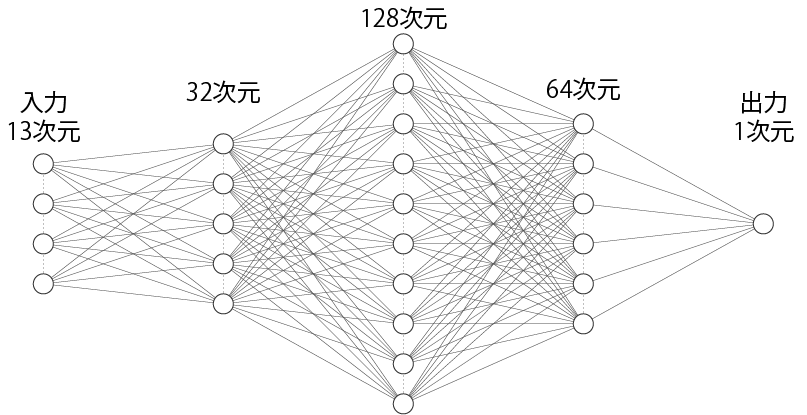

このコードでは、`torch.nn`モジュールのうち、各層で全結合層を示す`Linear`クラスとバッチ正規化を示す`BatchNorm1d`クラス、活性化関数である`ReLU`クラスを使用している。

一層目では、まず全結合層は13種類のmRNAを入力とし、それを隠れ層1で32個のノードに全結合させる。そのコードが、`nn.Linear(in_features = 13, out_features = num_features[0])`となっている (`num_features[0]`が32である) 。13個のノード (とバイアス) が32個のノードに結合しているニューラルネットワークをネットワークを想像して欲しい。それをバッチ正規化した後、活性化関数ReLUを適用している。

そして、二層目 (self.layers2) の入力特徴量数は先ほどの32であり、出力は128にしている。三層目 (self.layers3) では入力特徴量数128、出力は64である。最後に、全結合層で64の特徴量を1つの出力にしている。

次に、「2. 損失関数を使って、どの程度モデルが誤っているかを確認する」ための準備として損失関数を定義し、「5. オプティマイザで重みなどのパラメータ更新を行う」ための準備としてオプティマイザを定義する。

損失関数には、バイナリー交差エントロピー`BCEWithLogitsLoss`クラスを使用した。これは、出力特徴量を1にした全結合層 (`nn.Linear(out_features = 1`) を入力として、sigmoid変換 (確率への変換) とバイナリー交差エントロピーの損失計算を行う関数である。また、重み更新を行うオプティマイザには、汎用性が高く、最も用いられているオプティマイザの一つである**Adam**を用いる。

また、今回は損失関数と関連して、「どの程度モデルが正しいか」の指標としてaccuracyも定義しておく。

In [ ]:
# 3-1-6 損失関数とオプティマイザの定義
import torch.optim as optim

# GPUもモデルで使えるようにする (ランタイムを変更していない場合はそのままcpuで実行される)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = BinaryClassificationNet()
model.to(device)
print(model)

# 損失関数にはバイナリー交差エントロピーを示すBCEWithLogitsLossクラスを使う
loss_fn = nn.BCEWithLogitsLoss()

# 重み更新にはAdam (汎用性が高く、最も用いられているオプティマイザの一つ) を用いる
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# 学習過程でうまく学習できているかを監視するため、損失関数だけでなくaccuracyを確認する関数も定義
def binary_acc(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

このモデルを実際に訓練しよう。ここでは、訓練1エポックごとに、訓練データセットの`loss`と`accuracy`、そして検証データセットの`loss`と`accuracy`をリストに加えていくコードを書いている。

訓練では、まず`train_loader`から学習に使うmRNA発現量を示す`X_batch_train`と、ラベルを示す`y_batch_train`を抽出している。

その後、その`X_batch_train`に対して、

1. Forward関数を使って、順伝播処理を作る
2. 損失関数を使って、どの程度モデルが誤っているかを確認する
3. オプティマイザの勾配を0に初期化し、過去の勾配の影響を排除して現在の勾配を計算できるようにする
4. 誤差逆伝播法で損失関数の勾配を計算する
5. オプティマイザで重みなどのパラメータ更新を行う

というPyTorchの学習過程を適用している

ミニバッチでの計算が終わった後は、訓練データで得られた条件で検証データセットでの損失とaccuracyを計算している。計算後に次のエポックに移って再び訓練を行う。

さて、学習のエポック数だが、どれくらいにすればいいか不明である。仮にエポック数を400として実際に学習を行い、1エポックごとの訓練データと検証データでの`loss`と`accuracy`を確認してみよう。

In [ ]:
# 3-1-7 400エポックでモデルを訓練する
EPOCHS = 400

# トレーニングと検証を同時に行うforループを作る (まだテストデータセットは使わない)
model.train()

# 損失関数の出力とaccuracyはリストにまとめて後で図示する
train_loss_li = []
train_acc_li = []
val_loss_li = []
val_acc_li = []

# エポックは「全ての入力データを何回使えたか」、イテレーションは「重みを何度更新したか」を示す (訓練データセットは216種、バッチサイズ64で、'drop_last=True'より、1エポックあたり3イテレーションである)
for epoch in range(EPOCHS):
    # 訓練では、まず、ミニバッチごとに分けられたデータをfor文で一つずつ扱う
    for X_batch_train, y_batch_train in train_loader:
        # ミニバッチのデータをGPU上で動かしている
        X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

        # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る (squeezeでいらない次元を減らす)
        y_logits = model(X_batch_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
        loss = loss_fn(y_logits, y_batch_train)
        acc = binary_acc(y_true = y_batch_train, y_pred = y_pred)

        # 3. オプティマイザの勾配を0に初期化し、過去の勾配の影響を排除して現在の勾配を計算できるようにする
        optimizer.zero_grad()

        # 4. 誤差逆伝播法で損失関数の勾配を計算する
        loss.backward()

        # 5. オプティマイザで重みなどのパラメータ更新を行う
        optimizer.step()

    # 訓練データセットでミニバッチ学習が終わったところで、検証データセットの結果も確認する
    model.eval()

    # 検証では勾配が変動してはならないため、no_grad関数でテンソルの勾配計算ができないようにする
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る
            val_logits = model(X_batch_val).squeeze()
            val_pred = torch.round(torch.sigmoid(val_logits))

            # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
            val_loss = loss_fn(val_logits, y_batch_val)
            val_acc = binary_acc(y_true = y_batch_val, y_pred = val_pred)
            # 3以降は勾配の計算に関わってくるため、検証やテストでは使わない

    # 10 エポックごとに結果をまとめる
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train_loss: {loss:.5f}, Train_acc: {acc:.2f}% | Val_loss: {val_loss:.5f}, Val_acc: {val_acc:.2f}%')

    # 最後に、train_loss、train_acc、val_loss、val_accをリストにまとめる
    train_loss_li.append(loss.item())
    train_acc_li.append(acc)
    val_loss_li.append(val_loss.item())
    val_acc_li.append(val_acc)

In [ ]:
# 3-1-8 train_loss、val_loss、train_acc、val_accを図示して確認する
fig = plt.figure(figsize = (10, 6))

# add_subplot(221)とは、2*2に図を並べる際の1番目を指定している
ax1 = fig.add_subplot(221)
# ax1.set_xlabel('epochs', size = 16)
ax1.set_ylabel('loss', size = 16)
ax1.plot(train_loss_li, label = 'train_loss')
ax1.plot(val_loss_li, color = '#ff7f0e', label = 'val_loss')
ax1.axvline(x = 100, color = '#2ca02c')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.set_ylabel('acc', size = 16)
# ax2.set_xlabel('epochs', size = 16)
ax2.plot(train_acc_li, label = 'train_acc')
ax2.plot(val_acc_li, color = '#ff7f0e', label = 'val_acc')
ax2.axvline(x = 100, color = '#2ca02c')
ax2.legend()

# 最初の100エポックを拡大した図ものせる
ax3 = fig.add_subplot(223)
ax3.set_xlabel('epochs', size = 16)
ax3.set_ylabel('loss', size = 16)
ax3.plot(train_loss_li[0:100], label = 'train_loss')
ax3.plot(val_loss_li[0:100], color = '#ff7f0e', label = 'val_loss')
ax3.axvline(x = 100, color = '#2ca02c')
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.set_ylabel('accuracy', size = 16)
ax4.set_xlabel('epochs', size = 16)
ax4.plot(train_acc_li[0:100], label = 'train_accuracy')
ax4.plot(val_acc_li[0:100], color = '#ff7f0e', label = 'val_accuracy')
ax4.axvline(x = 100, color = '#2ca02c')
ax4.legend()

plt.show()

左上がエポックとlossの関係、右上がエポックとaccuracyの関係、左下がエポックとlossの関係のうち最初の100エポックを拡大したもの、右下がエポックとaccuracyの関係のうち最初の100エポックを拡大したものである。

エポック数が400もあると、訓練データセットでは損失が小さくなっていく反面、検証データセットでは途中から損失が増していく。これが**過学習**である。ニューラルネットワークでずっと訓練を続けていると、やがて訓練データのみに存在するつまらないパターンを学習し、検証データセットやテストデータセットに応用できなくなる。それで図のように検証データの損失が増え、やがては検証データセットのaccuracyも減少する。しかし、上図左下や右下のように、エポック数が100までであれば顕著な過学習は見られない。エポック数がちょうどよければ過学習を起こす前に訓練を終了できる。

そこで、過学習になりそうな段階で学習を中断してしまう**early stopping**を使う。残念ながら、`PyTorch`ライブラリにはearly stoppingのコールバックがデフォルトで存在しないため、自前で用意する必要がある。ここでは、[先人が過去に実装したearly stoppingの関数](https://github.com/Bjarten/early-stopping-pytorch)を扱う。この手法はMITライセンスのため、商用利用が可能である。その`EarlyStopping`クラスが以下である。

In [ ]:
# 3-1-9 先人が過去に実装したearly_stoppingのための関数 (参考: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py)
import numpy as np
import torch

class EarlyStopping:
    '''Early stopはval_lossが規定回数を経ても改善しなかった場合にそこで終了させる関数である'''

    def __init__(self, patience = 7, verbose = False, delta = 0, path = 'checkpoint.pt', trace_func = print):
        '''
        Args:
            patience (int): val_lossが最後に改善されてからpatienceで指定された回まで改善なければ終了
                            Default: 7
            verbose (bool): Trueなら, val_lossの改善状況を示す
                            Default: False
            delta (float): 改善と認定するための最小変化量。delta以下の改善は改善と認めない
                            Default: 0
            path (str): PyTorchモデルを保存するパス
                            Default: 'checkpoint.pt'
            trace_func (function): val_lossが更新されないとき、それが何回目を示す
                            Default: print
        '''
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        # -val_lossをscoreにすることで、val_lossを最小化する目標から、scoreを最大化する目標へ
        score = -val_loss

        # best_scoreがなければscoreを当面のbest_scoreにする
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        # scoreがbest_score+deltaに満たなければ棄却
        elif score < self.best_score + self.delta:
            # 棄却カウント1追加
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # 棄却カウントの合計がpatienceを超えたとき
            if self.counter >= self.patience:
                # Early stopで中止
                self.early_stop = True
        # scoreがそれまでのbest_scoreより大きいとき
        else:
            # scoreを更新
            self.best_score = score
            # modelとval_lossを保存
            self.save_checkpoint(val_loss, model)
            # 棄却カウントを0に戻す
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''val_lossが減少した際のmodelを保存する関数'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

これを用いて先程のニューラルネットワークを途中でearly stopさせ、その結果を図示してみる。

In [ ]:
# 3-1-10 エポック数400でearly_stoppingを含めた学習を行う
EPOCHS = 400

# early_stoppingを定義
early_stopping = EarlyStopping(patience = 10, verbose = True)

# モデルとオプティマイザを最初の条件に戻す
model = BinaryClassificationNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# トレーニングと検証を同時に行うforループを作る (まだテストデータセットは使わない)
model.train()

# 損失関数の出力とaccuracyはリストにまとめて後で図示する
train_loss_li = []
train_acc_li = []
val_loss_li = []
val_acc_li = []

# エポックは「全ての入力データを何回使えたか」、イテレーションは「重みを何度更新したか」を示す (訓練データセットは216種、バッチサイズ64で、drop_last = 'True'より、1エポックあたり3イテレーションである)
for epoch in range(EPOCHS):
    # 訓練では、まず、ミニバッチごとに分けられたデータをfor文で一つずつ扱う
    for X_batch_train, y_batch_train in train_loader:
        # ミニバッチのデータをGPU上で動かしている
        X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

        # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る (squeezeでいらない次元を減らす)
        y_logits = model(X_batch_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
        loss = loss_fn(y_logits, y_batch_train)
        acc = binary_acc(y_true = y_batch_train, y_pred = y_pred)

        # 3. オプティマイザの勾配を0に初期化し、過去の勾配の影響を排除して現在の勾配を計算できるようにする
        optimizer.zero_grad()

        # 4. 誤差逆伝播法で損失関数の勾配を計算する
        loss.backward()

        # 5. オプティマイザで重みなどのパラメータ更新を行う
        optimizer.step()

    # 訓練データセットでミニバッチ学習が終わったところで、検証データセットの結果も確認する
    model.eval()

    # 検証では勾配が変動してはならないため、no_grad関数でテンソルの勾配計算ができないようにする
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る
            val_logits = model(X_batch_val).squeeze()
            val_pred = torch.round(torch.sigmoid(val_logits))

            # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
            val_loss = loss_fn(val_logits, y_batch_val)
            val_acc = binary_acc(y_true = y_batch_val, y_pred = val_pred)
            # 3以降は勾配の計算に関わってくるため、検証やテストでは使わない

    # 10 エポックごとに結果をまとめる
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train_loss: {loss:.5f}, Train_acc: {acc:.2f}% | Val_loss: {val_loss:.5f}, Val_acc: {val_acc:.2f}%')

    # 最後に、train_loss、train_acc、val_loss、val_accをリストにまとめる
    train_loss_li.append(loss.item())
    train_acc_li.append(acc)
    val_loss_li.append(val_loss.item())
    val_acc_li.append(val_acc)

    # early_stoppingを適用
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        # 一定epochだけval_lossが最低値を更新しなかった場合、ここに入り学習を終了
        break

In [ ]:
# 3-1-11 途中でearly stopした結果を図示する
fig = plt.figure(figsize = (10, 6))

# 結局何エポックでstopしたかを表示
print(len(val_loss_li))

# add_subplot(121)とは、1*2に図を並べる際の1番目を指定している
ax1 = fig.add_subplot(121)
ax1.set_xlabel('epochs', size = 16)
ax1.set_ylabel('loss', size = 16)
ax1.plot(train_loss_li, label = 'train_loss')
ax1.plot(val_loss_li, color = '#ff7f0e', label = 'val_loss')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_ylabel('acc', size = 16)
ax2.set_xlabel('epochs', size = 16)
ax2.plot(train_acc_li, label = 'train_acc')
ax2.plot(val_acc_li, color = '#ff7f0e', label = 'val_acc')
ax2.legend()

plt.show()

30エポック程度で学習が停止し、思惑通り過学習前に中断できた。検証データでも良いスコアで、過学習はしていないと考えられる。このモデルは`checkpoint.pt`に保存されている。これを`model.load_state_dict`メソッドで読み込んで、テストデータセットに適用しよう。

In [ ]:
# 3-1-12 early_stoppingした時のモデルは保存されているため、これをロードする
model_path = 'checkpoint.pt'
model.load_state_dict(torch.load(model_path))

In [ ]:
# 3-1-13 itertoolsでリストを処理する
import itertools

# 予測確率をリストにまとめる
test_prob_list = []

# 予測ラベルをリストにまとめる
test_pred_list = []

# 訓練データセットでミニバッチ学習が終わったところで、テストデータセットの結果も確認する
model.eval()

# 検証では勾配が変動してはならないため、no_grad関数でテンソルの勾配計算ができないようにする
with torch.no_grad():
    for X_batch_test, y_batch_test in test_loader:
        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

        # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る
        test_logits = model(X_batch_test).squeeze()
        test_prob = torch.sigmoid(test_logits)
        # 確率をリストに
        test_prob_list.append(test_prob.cpu().numpy())
        test_pred = torch.round(test_prob)
        # ラベルをリストに
        test_pred_list.append(test_pred.cpu().numpy())

        # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
        test_loss = loss_fn(test_logits, y_batch_test)
        test_acc = binary_acc(y_true = y_batch_test, y_pred = test_pred)
        # 3以降は勾配の計算に関わってくるため、検証やテストでは使わない

test_prob_list = list(itertools.chain.from_iterable(test_prob_list))
test_pred_list = list(itertools.chain.from_iterable(test_pred_list))

この学習結果を、ROC-AUC曲線、混同行列、classification_reportで確認しよう。

In [ ]:
# 3-1-14 ROC曲線
from sklearn.metrics import auc, roc_curve

# ROC-AUC
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_prob_list)
auc_test = auc(fpr_test, tpr_test)

# plotを作成
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr_test, tpr_test, label = 'EarlyStopping+NeuralNetwork (AUC = %.3f)' % auc_test)
plt.fill_between(fpr_test, tpr_test, 0, alpha = 0.1)
plt.legend()
plt.title('EarlyStopping+NeuralNetwork')
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.grid(True)
plt.show()

In [ ]:
# 3-1-15 混同行列とclassification_report
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, test_pred_list))
print(classification_report(y_test, test_pred_list))

結果、ROC-AUCは1.000、混同行列は$\begin{bmatrix}
49 & 0 \\
4 & 56 \\
\end{bmatrix}
$に、accuracyは0.96となった。

ニューラルネットワークでも肝細胞がんと隣接正常肝臓を二値分類できると考えられる。PyTorchのコードには型があり、ニューラルネットワークの動作原理に沿っているため、経験を積むと読みやすく書きやすい。また、エポック数が多すぎる場合には、訓練データセットのみでスコアが上がり、検証データセットでは分類できないような**過学習**に陥ることがある。その場合、early stoppingでエポックを中断すると汎化性能が上がる。

## 3-2. ベイズ最適化によるハイパーパラメータの調整

この時点で十分に良い結果が得られているが、最後にハイパーパラメータの最適化を行って終わることにする。グリッドサーチでは時間がかかるため、optunaによる最適化を行う。

この節では、前節で用いた`torch.nn`モジュールの`Sequential`クラスではなく`ModuleList`クラスを使ってモデルを作る。ニューラルネットワークの層数をハイパーパラメータにする際に、`Sequential`クラスだと書きにくいのである。`ModuleList`クラスで定義した`self.layers`にforループとappendを用いて活性化関数やバッチ正規化などの演算を追加していく。

In [ ]:
# 3-2-1 コードに再現性をもたせるためにシードを固定し、データローダーを初期化しておく
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

BATCH_SIZE = 64
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
val_loader = DataLoader(dataset = val_data, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE)

In [ ]:
# 3-2-2 ニューラルネットワークモデルの定義
import torch.nn as nn

class BinaryClassificationNet(nn.Module):
    # init関数で使用するレイヤーを定義
    def __init__(self, trial, num_layers, num_features):
        super(BinaryClassificationNet, self).__init__()

        # 第1層は入力特徴量を13、出力をnum_features[0]にする
        self.layers = nn.ModuleList([nn.Linear(in_features = 13, out_features = num_features[0])])
        self.layers.append(nn.BatchNorm1d(num_features[0]))
        self.layers.append(nn.ReLU())

        # 第2層以降はfor文で層を重ねていく
        for i in range(1, num_layers):
            self.layers.append(nn.Linear(in_features = num_features[i - 1], out_features = num_features[i]))
            self.layers.append(nn.BatchNorm1d(num_features[i]))
            self.layers.append(nn.ReLU())
        # 最後に先の出力のnum_features[i]を1にする
        self.layers_out = nn.Linear(in_features = num_features[i], out_features = 1)

    # forward関数で定義済みレイヤーを呼び出す
    def forward(self, x):
        for i, l in enumerate(self.layers):
            # l(x)でモデルを使う
            x = l(x)
        # sigmoidは損失関数に含まれているので設定しなくて良い
        x = self.layers_out(x)
        return x

重みの更新方法であるオプティマイザに`'Adam'`を使うか`'RMSprop'`を使うか、optunaに選ばせる。オプティマイザを使う際の学習率も、範囲だけ決めてoptunaに選ばせる。また、`'weight_decay'`は重みが大きすぎることによる過学習を防ぐために重みを小さくするための値だが、これもoptunaに頼むことにしよう。

In [ ]:
# 3-2-3 どのoptimizerを使うかというところから最適化する
import torch.optim as optim

def get_optimizer(trial, model):
    optimizer_names = ['Adam', 'RMSprop']
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
    weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-2, log = True)
    if optimizer_name == optimizer_names[0]:
        Adam_lr = trial.suggest_float('Adam_lr', 1e-5, 1e-1, log = True)
        optimizer = optim.Adam(model.parameters(), lr = Adam_lr, weight_decay = weight_decay)
    else:
        RMSprop_lr = trial.suggest_float('RMSprop_lr', 1e-5, 1e-1, log = True)
        optimizer = optim.RMSprop(model.parameters(), lr = RMSprop_lr, weight_decay = weight_decay)
    return optimizer

モデルをトレーニングするための`train`関数と検証するための`val`関数を定義する。

In [ ]:
# 3-2-4 損失関数とニューラルネットワークの訓練・検証用の関数を定義
loss_fn = nn.BCEWithLogitsLoss()

def train(model, device, train_loader, optimizer):
    model.train()
    for epoch in range(EPOCHS):
        for X_batch_train, y_batch_train in train_loader:
            # ミニバッチのデータをGPUに適用する
            X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

            # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る (squeezeでいらない次元を減らす)
            y_logits = model(X_batch_train).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する
            loss = loss_fn(y_logits, y_batch_train)

            # 3. オプティマイザの勾配を0に初期化し、過去の勾配の影響を排除して現在の勾配を計算できるようにする
            optimizer.zero_grad()

            # 4. 誤差逆伝播法で損失関数の勾配を計算する
            loss.backward()

            # 5. オプティマイザで重みなどのパラメータ更新を行う
            optimizer.step()

def val(model, device, val_loader):
    model.eval()
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る
            val_logits = model(X_batch_val).squeeze()
            val_pred = torch.round(torch.sigmoid(val_logits))

            # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する
            val_loss = loss_fn(val_logits, y_batch_val)
    return val_loss

ベイズ最適化で重要な目的関数を定義する。今回は`val_loss`を出力し、それを最小化する方向とする。目的関数には層数、全結合層の特徴量数をそれぞれoptunaに選ばせるように設定している。

また、ニューラルネットワークなのでエポック数も指定せねばならないが、エポック数を大きくすると時間がかかる。3-1の経験から、30エポック程度で問題ないだろう。

In [ ]:
# 3-2-5 ニューラルネットワークの目的関数の定義
EPOCHS = 30

def objective_nn(trial):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # 層の数は3から7の間に
    num_layers = trial.suggest_int('num_layer', 3, 7)
    # 全結合層の特徴量数
    num_features = [
        int(trial.suggest_float(f'num_features_{i}', 16, 128, step = 16))
        for i in range(num_layers)
    ]

    model = BinaryClassificationNet(trial, num_layers, num_features).to(device)
    optimizer = get_optimizer(trial, model)

    for step in range(EPOCHS):
        train(model, device, train_loader, optimizer)
        val_loss = val(model, device, val_loader)
    return val_loss

実際にハイパーパラメータのベイズ最適化を25回行う。

In [ ]:
# 3-2-6 ハイパーパラメータのベイズ最適化
from functools import partial
import optuna

obj_nn = partial(objective_nn)

# セッションの作成
sampler = optuna.samplers.TPESampler(seed = 0)

# val_lossを最小化するためにdirection = 'minimize'にする
study_nn = optuna.create_study(sampler = sampler, direction = 'minimize')

# 回数を指定する (30回だとおよそ10分程度かかる場合があります)
study_nn.optimize(obj_nn, n_trials = 30)

In [ ]:
# 3-2-7 最適な結果の確認
study_nn.best_value

In [ ]:
# 3-2-8 最適なパラメータの確認
nn_params = study_nn.best_params
nn_params

こうしてoptunaに選ばれたハイパーパラメータを実用してみよう。

In [ ]:
# 3-2-9 最適なモデルの実装
class BinaryClassificationNet(nn.Module):
    # init関数で使用するレイヤーを定義
    def __init__(self):

        # torch.nnモジュールのmoduleクラスを基底クラスとして継承する (ニューラルネットワークの基本機能が使えるようになるおまじないと考えて良い)
        super(BinaryClassificationNet, self).__init__()

        # 第1層は入力特徴量を13、出力をnum_features[0]にする
        self.layers = nn.ModuleList([nn.Linear(in_features = 13, out_features = num_features[0])])
        self.layers.append(nn.BatchNorm1d(num_features[0]))
        self.layers.append(nn.ReLU())

        # 第2層以降はfor文で層を重ねていく
        for i in range(1, num_layers):
            self.layers.append(nn.Linear(in_features = num_features[i - 1], out_features = num_features[i]))
            self.layers.append(nn.BatchNorm1d(num_features[i]))
            self.layers.append(nn.ReLU())
        # 最後に先の出力のnum_features[i]を1にする
        self.layers_out = nn.Linear(in_features = num_features[i], out_features = 1)

    # forward関数で定義済みレイヤーを呼び出す
    def forward(self, x):
        for i, l in enumerate(self.layers):
            # l(x)でモデルを使う
            x = l(x)
        # sigmoidは損失関数に含まれているので設定しなくて良い
        x = self.layers_out(x)
        return x

ハイパーパラメータは先程用意した`nn_params`から、`nn_params['num_layer']`などのように抽出すると良い。

In [ ]:
# 3-2-10 最適化したハイパーパラメータ情報を入れる
# リスト内包表記で各パラメータを用意
num_layers = nn_params['num_layer']

# num_featuresはint関数で整数に変換しないとエラーを起こす
num_features = [int(nn_params[f'num_features_{i}']) for i in range(nn_params['num_layer'])]

# モデルを構築し、GPUへ
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = BinaryClassificationNet()
model.to(device)
print(model)

# 損失関数にはバイナリー交差エントロピーを示すBCEWithLogitsLossクラスを使い、シグモイド変換も行う
loss_fn = nn.BCEWithLogitsLoss()

# 最適化したoptimizerを使用する
optimizer_names = ['Adam', 'RMSprop']
weight_decay = nn_params['weight_decay']
if nn_params['optimizer'] == optimizer_names[0]:
    Adam_lr = nn_params['Adam_lr']
    optimizer = optim.Adam(model.parameters(), lr = Adam_lr, weight_decay = weight_decay)
else:
    RMSprop_lr = nn_params['RMSprop_lr']
    optimizer = optim.RMSprop(model.parameters(), lr = RMSprop_lr, weight_decay = weight_decay)

# 学習過程でうまく学習できているかを監視するため、損失関数だけでなくaccuracyを確認する関数も定義
def binary_acc(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# 3-2-11 30エポックでモデルを訓練する
EPOCHS = 30

# トレーニングと検証を同時に行うforループを作る (まだテストデータセットは使わない)
model.train()

# 損失関数の出力とaccuracyはリストにまとめて後で図示する
train_loss_li = []
train_acc_li = []
val_loss_li = []
val_acc_li = []

# エポック: 全ての入力データを何回使えたかを示す
for epoch in range(EPOCHS):
    # 訓練では、まず、ミニバッチごとに分けられたデータをfor文で一つずつ扱う
    for X_batch_train, y_batch_train in train_loader:
        # ミニバッチのデータをGPU上で動かしている
        X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

        # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る (squeezeでいらない次元を減らす)
        y_logits = model(X_batch_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
        loss = loss_fn(y_logits, y_batch_train)
        acc = binary_acc(y_true = y_batch_train, y_pred = y_pred)

        # 3. オプティマイザの勾配を0に初期化し、過去の勾配の影響を排除して現在の勾配を計算できるようにする
        optimizer.zero_grad()

        # 4. 誤差逆伝播法で損失関数の勾配を計算する
        loss.backward()

        # 5. オプティマイザで重みなどのパラメータ更新を行う
        optimizer.step()

    # 検証データでの確認 (訓練データの後に検証データを確認)
    model.eval()

    # no_grad関数でテンソルの勾配計算ができないようにする
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る
            val_logits = model(X_batch_val).squeeze()
            val_pred = torch.round(torch.sigmoid(val_logits))

            # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
            val_loss = loss_fn(val_logits, y_batch_val)
            val_acc = binary_acc(y_true = y_batch_val, y_pred = val_pred)
            # 3以降は勾配の計算に関わってくるため、検証やテストでは書かない

        print(f'Epoch: {epoch} | Train_loss: {loss:.5f}, Train_acc: {acc:.2f}% | Val_loss: {val_loss:.5f}, Val_acc: {val_acc:.2f}%')

    val_loss_li.append(val_loss.item())
    val_acc_li.append(val_acc)

    train_loss_li.append(loss.item())
    train_acc_li.append(acc)

In [ ]:
# 3-2-12 結果の図示
fig = plt.figure(figsize = (10, 6))

ax1 = fig.add_subplot(121)
ax1.set_ylabel('loss', size = 16)
ax1.set_ylabel('loss', size = 16)
ax1.plot(train_loss_li, label = 'train_loss')
ax1.plot(val_loss_li, color = '#ff7f0e', label = 'val_loss')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_ylabel('acc', size = 16)
ax2.plot(train_acc_li, label = 'train_acc')
ax2.plot(val_acc_li, color = '#ff7f0e', label = 'val_acc')
ax2.legend()

plt.show()

検証データでも良いスコアで、過学習はしていないと考えられる。このモデルをテストデータセットに適用しよう。

In [ ]:
# 3-2-13 itertoolsでリストを処理する
import itertools

# 予測確率をリストにまとめる
test_prob_list = []
# 予測ラベルをリストにまとめる
test_pred_list = []

# 訓練データセットでミニバッチ学習が終わったところで、テストデータセットの結果も確認する
model.eval()

# 検証では勾配が変動してはならないため、no_grad関数でテンソルの勾配計算ができないようにする
with torch.no_grad():
    for X_batch_test, y_batch_test in test_loader:
        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

        # 1. Forward関数を使って、図で言えば左から右の順伝播処理を作る
        test_logits = model(X_batch_test).squeeze()
        test_prob = torch.sigmoid(test_logits)
        test_prob_list.append(test_prob.cpu().numpy())
        test_pred = torch.round(test_prob)
        test_pred_list.append(test_pred.cpu().numpy())

        # 2. 損失関数を使って、どの程度モデルが誤っているかを確認する (ここではaccuracyも使う)
        test_loss = loss_fn(test_logits, y_batch_test)
        test_acc = binary_acc(y_true = y_batch_test, y_pred = test_pred)
        # 3以降は勾配の計算に関わってくるため、検証やテストでは使わない

test_prob_list = list(itertools.chain.from_iterable(test_prob_list))
test_pred_list = list(itertools.chain.from_iterable(test_pred_list))

この学習結果を、混同行列、classification_report、ROC-AUC曲線で確認しよう。

In [ ]:
# 3-2-14 ROC曲線
from sklearn.metrics import auc, roc_curve

# ROC-AUCの計算
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_prob_list)
auc_test = auc(fpr_test, tpr_test)

# plotの作成
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr_test, tpr_test, label = 'Optuna+NeuralNetwork (AUC = %.3f)' % auc_test)
plt.fill_between(fpr_test, tpr_test, 0, alpha = 0.1)
plt.legend()
plt.title('Optuna+NeuralNetwork')
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.grid(True)
plt.show()

In [ ]:
# 3-2-15 混同行列とclassification_report
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, test_pred_list))
print(classification_report(y_test, test_pred_list))

ベイズ最適化では、ROC-AUCは1.000、混同行列は$\begin{bmatrix}
49 & 0 \\
1 & 59 \\
\end{bmatrix}
$、accuracyは0.99となった。

さて、ここまで作ってきたモデルのスコアを確認すると、意外とサポートベクトルマシンが健闘していることがわかる。例えば、混同行列は最も良くて$\begin{bmatrix}
49 & 0 \\
1 & 59 \\
\end{bmatrix}
$だったが、これを達成したのは2-2のグリッドサーチを用いたサポートベクトルマシン、2-3のベイズ最適化を用いたサポートベクトルマシン、そして、3-2のベイズ最適化を用いた深層学習である。

深層学習は確かに有用だが、実際には機械学習アルゴリズムで十分良いスコアを達成できることは少なくない。深層学習でしかできないような難解なタスクもあるが、そうでない場合は是非機械学習アルゴリズムも活用してみてほしい。